In [69]:
import pyforest
import sys
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/')
# from updated_RF import *
from RF_functions import *
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem


import math
import torch
import numpy as np
# import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import shutil
import matplotlib 
# matplotlib.use('Agg')

from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

# from scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys


from sklearn.model_selection import GridSearchCV

In [70]:
gp_results='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/gp_kfold_results/'

rf_results='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/rf_models/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MOE','MFP'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']
folds=['fold1','fold2','fold3','fold4','fold5'] 

In [71]:
rf_kfold_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_kfold_results/'

# rf_kfold_results1 = pd.read_csv(f'{rf_kfold_path}RF_test_results_all_NEK_kfold_val_5x.csv') # same thing as below 
rf_kfold_results1 = pd.read_csv(f'{rf_kfold_path}repeated0-5_RF_test_results_all_NEK_kfold_val_5x.csv')

print(rf_kfold_results1['iteration'].value_counts())

rf_kfold_results2 = pd.read_csv(f'{rf_kfold_path}RF_test_results_all_NEK_kfold_val_5x_6-10.csv')
rf_kfold_results2['iteration'] = rf_kfold_results2['iteration']+5
rf_kfold_results2['model'] = rf_kfold_results2['model'].str[:-1] + (rf_kfold_results2['iteration'].astype(str))
rf_kfold_nersc = pd.concat([rf_kfold_results1, rf_kfold_results2])
rf_kfold_nersc.shape
# rf_kfold_nersc.to_csv(f'{rf_kfold_path}RF_test_resufold_val_5x_NERSC.csv', index=False)

iteration
0    960
1    960
2    960
3    960
4    960
Name: count, dtype: int64


(9600, 18)

In [72]:
# RF kfold Results
# rf = pd.read_csv(f'{rf_results}RF_test_results_all_NEK_kfold_val_10x.csv')
rf = rf_kfold_nersc
rf=rf[rf['strategy']!='ADASYN']
rf['1-specificity']=1-rf['specificity']
rf['nek type'] = rf['NEK'].astype(str).str.split('_').str[1]

rf=rf.replace('none_scaled', 'no_sampling')


rf_raw = rf[(rf['strategy'] == 'no_sampling') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'SMOTE', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
total_rf = rf_filtered.copy() 
total_rf['strategy'] =total_rf['strategy'].astype(str) +'_'+ total_rf['RF_type']


binding_rf = total_rf[total_rf['nek type'] == 'binding'] 
inhib_rf = total_rf[total_rf['nek type'] == 'inhibition'] 


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_3279/2355693950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf['1-specificity']=1-rf['specificity']
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_3279/2355693950.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf['nek type'] = rf['NEK'].astype(str).str.split('_').str[1]


In [73]:
samp_palette={'no_sampling': 'tab:blue', 'UNDER':'tab:orange', 'SMOTE': 'hotpink', 'ADASYN':'tab:red', 
             'no_sampling_RF': 'cornflowerblue', 'no_sampling_RF_BCW': 'lavender', 'UNDER_RF': 'orange', 
             'no_sampling_BRFC': 'blue', 'SMOTE_RF': 'hotpink', 'ADASYN_RF': 'red', 
             'no_sampling_BRFC_BCW': 'black'}

model_types_dict= {'RF': 's', 'GP':'X', 'GP_matern': 'X', 'GP_RBF': 'd' }

In [74]:
gp = pd.read_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val_10x.csv')
gp=gp[gp['strategy']!='ADASYN']
gp['1-specificity']=1-gp['specificity']
gp['nek type'] = gp['NEK'].astype(str).str.split('_').str[1]

gp=gp.replace('none', 'no_sampling')
gp=gp.replace('none_scaled', 'no_sampling')
gp['strategy'] =gp['strategy'].astype(str) +'_'+ gp['kernel_type']
gp['modeling_type'] = gp['kernel_type']
binding_gp = gp[gp['nek type'] == 'binding'] 
inhib_gp = gp[gp['nek type'] == 'inhibition'] 
gp_strategies=['no_sampling_GP_RBF', 'no_sampling_GP_matern', 'UNDER_GP_RBF',
       'UNDER_GP_matern', 'SMOTE_GP_RBF', 'SMOTE_GP_matern',
       'ADASYN_GP_RBF', 'ADASYN_GP_matern']
gen_colors = ['cornflowerblue', 'orange', 'hotpink','red'] 

for kern in ['RBF','matern']: 
    for samp, color in zip(['no_sampling','UNDER','SMOTE','ADASYN'], gen_colors): 
        gp_type = f'{samp}_GP_{kern}'
        samp_palette[gp_type]=color

binding= pd.concat([binding_rf, binding_gp])
inhib= pd.concat([inhib_rf, inhib_gp])
inhib['strategy'].unique()

array(['no_sampling_RF', 'no_sampling_RF_BCW', 'no_sampling_BRFC',
       'no_sampling_BRFC_BCW', 'UNDER_RF', 'SMOTE_RF',
       'no_sampling_GP_RBF', 'no_sampling_GP_matern', 'UNDER_GP_RBF',
       'UNDER_GP_matern', 'SMOTE_GP_RBF', 'SMOTE_GP_matern'], dtype=object)

In [75]:
all_data = pd.concat([binding, inhib])
all_data.to_csv('kfold_results_temp.csv', index=False)
all_data['NEK'].value_counts()

In [77]:
all_data['modeling_type'].value_counts()
col_order =['NEK', 'strategy', 'feat_type','f1','recall','specificity','distance', 'fbeta_2','balanced_accuracy', '1-specificity','MCC','f1']
col_order2 =['NEK', 'strategy', 'feat_type','balanced_accuracy','recall','1-specificity']
all_bas = []
for nek in neks: 
    nek_df = all_data[all_data['NEK']==nek]
    print(nek)
    avg50 = nek_df.groupby(['NEK','strategy', 'modeling_type', 'feat_type'])[['recall', '1-specificity', 'balanced_accuracy']].mean()
    # top_neks=nek_df.sort_values(['balanced_accuracy'], ascending=False).head(1)
    # display(top_neks[col_order].head(1)) 
    # display(top_neks)
    all_bas.append(avg50)
    
   
    display(avg50.sort_values(['balanced_accuracy'],ascending=False))
# best_ba_df = pd.DataFrame(best_bas)


NEK2_binding


recall  \
NEK          strategy              modeling_type feat_type             
NEK2_binding UNDER_GP_matern       GP_matern     MFP        0.688889   
             UNDER_GP_RBF          GP_RBF        MFP        0.702222   
             no_sampling_BRFC      RF            MFP        0.671111   
             UNDER_GP_matern       GP_matern     MOE        0.677778   
             no_sampling_RF_BCW    RF            MFP        0.428889   
             UNDER_RF              RF            MFP        0.673333   
             no_sampling_RF        RF            MFP        0.357778   
             no_sampling_BRFC      RF            MOE        0.602222   
             SMOTE_GP_RBF          GP_RBF        MOE        0.311111   
             SMOTE_RF              RF            MFP        0.351111   
                                                 MOE        0.335556   
             SMOTE_GP_matern       GP_matern     MOE        0.284444   
             no_sampling_RF_BCW    RF            MOE        0.275556   
             UNDER_RF              RF            MOE        0.644444   
             no_sampling_BRFC_BCW  RF            MOE        0.555556   
             SMOTE_GP_RBF          GP_RBF        MFP        0.224444   
             no_sampling_BRFC_BCW  RF            MFP        0.806667   
             SMOTE_GP_matern       GP_matern     MFP        0.208889   
             no_sampling_RF        RF            MOE        0.153333   
             no_sampling_GP_RBF    GP_RBF        MFP        0.000000   
                                                 MOE        0.000000   
             no_sampling_GP_matern GP_matern     MFP        0.000000   
                                                 MOE        0.000000   
             UNDER_GP_RBF          GP_RBF        MOE        0.000000   

                                                            1-specificity  \
NEK          strategy              modeling_type feat_type                  
NEK2_binding UNDER_GP_matern       GP_matern     MFP             0.140278   
             UNDER_GP_RBF          GP_RBF        MFP             0.178426   
             no_sampling_BRFC      RF            MFP             0.178704   
             UNDER_GP_matern       GP_matern     MOE             0.281296   
             no_sampling_RF_BCW    RF            MFP             0.043056   
             UNDER_RF              RF            MFP             0.328704   
             no_sampling_RF        RF            MFP             0.028981   
             no_sampling_BRFC      RF            MOE             0.286944   
             SMOTE_GP_RBF          GP_RBF        MOE             0.007963   
             SMOTE_RF              RF            MFP             0.051574   
                                                 MOE             0.053241   
             SMOTE_GP_matern       GP_matern     MOE             0.004722   
             no_sampling_RF_BCW    RF            MOE             0.035185   
             UNDER_RF              RF            MOE             0.414815   
             no_sampling_BRFC_BCW  RF            MOE             0.326759   
             SMOTE_GP_RBF          GP_RBF        MFP             0.004167   
             no_sampling_BRFC_BCW  RF            MFP             0.598889   
             SMOTE_GP_matern       GP_matern     MFP             0.002963   
             no_sampling_RF        RF            MOE             0.041019   
             no_sampling_GP_RBF    GP_RBF        MFP             0.000000   
                                                 MOE             0.000000   
             no_sampling_GP_matern GP_matern     MFP             0.000000   
                                                 MOE             0.000000   
             UNDER_GP_RBF          GP_RBF        MOE             0.000000   

                                                            balanced_accuracy  
NEK          strategy              modeling_type feat_type                     
NEK2_binding UNDER_GP_mate

NEK2_inhibition


recall  \
NEK             strategy              modeling_type feat_type             
NEK2_inhibition UNDER_GP_matern       GP_matern     MFP        0.853518   
                UNDER_GP_RBF          GP_RBF        MFP        0.863399   
                no_sampling_BRFC      RF            MFP        0.865336   
                                                    MOE        0.797312   
                UNDER_GP_matern       GP_matern     MOE        0.822016   
                UNDER_RF              RF            MFP        0.850158   
                no_sampling_RF_BCW    RF            MFP        0.700830   
                SMOTE_RF              RF            MFP        0.665771   
                SMOTE_GP_RBF          GP_RBF        MFP        0.622964   
                                                    MOE        0.617905   
                no_sampling_RF        RF            MFP        0.633834   
                SMOTE_GP_matern       GP_matern     MOE        0.600000   
                                                    MFP        0.584427   
                no_sampling_BRFC_BCW  RF            MFP        0.881225   
                                                    MOE        0.779289   
                SMOTE_RF              RF            MOE        0.581502   
                UNDER_RF              RF            MOE        0.764071   
                no_sampling_RF_BCW    RF            MOE        0.501107   
                no_sampling_RF        RF            MOE        0.497391   
                UNDER_GP_RBF          GP_RBF        MOE        0.532688   
                no_sampling_GP_RBF    GP_RBF        MFP        0.115968   
                                                    MOE        0.050277   
                no_sampling_GP_matern GP_matern     MFP        0.020474   
                                                    MOE        0.000000   

                                                               1-specificity  \
NEK             strategy              modeling_type feat_type                  
NEK2_inhibition UNDER_GP_matern       GP_matern     MFP             0.082958   
                UNDER_GP_RBF          GP_RBF        MFP             0.092998   
                no_sampling_BRFC      RF            MFP             0.103570   
                                                    MOE             0.117183   
                UNDER_GP_matern       GP_matern     MOE             0.141903   
                UNDER_RF              RF            MFP             0.173128   
                no_sampling_RF_BCW    RF            MFP             0.037344   
                SMOTE_RF              RF            MFP             0.045741   
                SMOTE_GP_RBF          GP_RBF        MFP             0.010775   
                                                    MOE             0.013352   
                no_sampling_RF        RF            MFP             0.030008   
                SMOTE_GP_matern       GP_matern     MOE             0.010377   
                                                    MFP             0.007931   
                no_sampling_BRFC_BCW  RF            MFP             0.314161   
                                                    MOE             0.216119   
                SMOTE_RF              RF            MOE             0.053072   
                UNDER_RF              RF            MOE             0.245295   
                no_sampling_RF_BCW    RF            MOE             0.033047   
                no_sampling_RF        RF            MOE             0.039062   
                UNDER_GP_RBF          GP_RBF        MOE             0.083967   
                no_sampling_GP_RBF    GP_RBF        MFP             0.000198   
                                                    MOE             0.000000   
                no_sampling_GP_matern GP_matern     MFP             0.000000   
                                                    MOE             0.000000   

                                 

NEK3_binding


recall  \
NEK          strategy              modeling_type feat_type             
NEK3_binding no_sampling_BRFC      RF            MFP        0.671667   
             UNDER_GP_matern       GP_matern     MFP        0.607821   
             UNDER_GP_RBF          GP_RBF        MFP        0.563846   
             UNDER_RF              RF            MFP        0.609615   
             no_sampling_BRFC      RF            MOE        0.630000   
             no_sampling_RF_BCW    RF            MFP        0.291667   
             no_sampling_BRFC_BCW  RF            MFP        0.732821   
                                                 MOE        0.563333   
             no_sampling_RF        RF            MFP        0.230128   
             SMOTE_RF              RF            MFP        0.218462   
                                                 MOE        0.217179   
             UNDER_GP_matern       GP_matern     MOE        0.476154   
             SMOTE_GP_RBF          GP_RBF        MFP        0.117564   
             no_sampling_RF        RF            MOE        0.133846   
             no_sampling_RF_BCW    RF            MOE        0.131410   
             SMOTE_GP_RBF          GP_RBF        MOE        0.084744   
             SMOTE_GP_matern       GP_matern     MOE        0.078590   
             UNDER_RF              RF            MOE        0.518974   
             SMOTE_GP_matern       GP_matern     MFP        0.050256   
             UNDER_GP_RBF          GP_RBF        MOE        0.015385   
             no_sampling_GP_RBF    GP_RBF        MFP        0.000000   
                                                 MOE        0.000000   
             no_sampling_GP_matern GP_matern     MFP        0.000000   
                                                 MOE        0.000000   

                                                            1-specificity  \
NEK          strategy              modeling_type feat_type                  
NEK3_binding no_sampling_BRFC      RF            MFP             0.258966   
             UNDER_GP_matern       GP_matern     MFP             0.248655   
             UNDER_GP_RBF          GP_RBF        MFP             0.268706   
             UNDER_RF              RF            MFP             0.324295   
             no_sampling_BRFC      RF            MOE             0.372412   
             no_sampling_RF_BCW    RF            MFP             0.065691   
             no_sampling_BRFC_BCW  RF            MFP             0.519501   
                                                 MOE             0.360773   
             no_sampling_RF        RF            MFP             0.037235   
             SMOTE_RF              RF            MFP             0.072867   
                                                 MOE             0.083173   
             UNDER_GP_matern       GP_matern     MOE             0.347954   
             SMOTE_GP_RBF          GP_RBF        MFP             0.008693   
             no_sampling_RF        RF            MOE             0.051414   
             no_sampling_RF_BCW    RF            MOE             0.053583   
             SMOTE_GP_RBF          GP_RBF        MOE             0.012194   
             SMOTE_GP_matern       GP_matern     MOE             0.009073   
             UNDER_RF              RF            MOE             0.468254   
             SMOTE_GP_matern       GP_matern     MFP             0.004347   
             UNDER_GP_RBF          GP_RBF        MOE             0.008491   
             no_sampling_GP_RBF    GP_RBF        MFP             0.000000   
                                                 MOE             0.000000   
             no_sampling_GP_matern GP_matern     MFP             0.000000   
                                                 MOE             0.000000   

                                                            balanced_accuracy  
NEK          strategy              modeling_type feat_type                     
NEK3_binding no_sampling_B

NEK5_binding


recall  \
NEK          strategy              modeling_type feat_type             
NEK5_binding UNDER_GP_matern       GP_matern     MFP        0.814000   
             no_sampling_BRFC      RF            MFP        0.841250   
             UNDER_GP_RBF          GP_RBF        MFP        0.811417   
             UNDER_RF              RF            MFP        0.786000   
             no_sampling_BRFC_BCW  RF            MFP        0.833250   
             no_sampling_RF        RF            MFP        0.557833   
             no_sampling_RF_BCW    RF            MFP        0.563667   
             no_sampling_BRFC      RF            MOE        0.737250   
             SMOTE_GP_RBF          GP_RBF        MFP        0.507250   
             SMOTE_RF              RF            MFP        0.551750   
             UNDER_GP_matern       GP_matern     MOE        0.725750   
             no_sampling_BRFC_BCW  RF            MOE        0.694083   
             SMOTE_GP_matern       GP_matern     MFP        0.415333   
             SMOTE_GP_RBF          GP_RBF        MOE        0.422000   
             SMOTE_GP_matern       GP_matern     MOE        0.419583   
             UNDER_RF              RF            MOE        0.675917   
             SMOTE_RF              RF            MOE        0.391583   
             no_sampling_RF        RF            MOE        0.360333   
             no_sampling_RF_BCW    RF            MOE        0.347250   
             UNDER_GP_RBF          GP_RBF        MOE        0.151833   
             no_sampling_GP_RBF    GP_RBF        MFP        0.029833   
                                                 MOE        0.000000   
             no_sampling_GP_matern GP_matern     MFP        0.000000   
                                                 MOE        0.000000   

                                                            1-specificity  \
NEK          strategy              modeling_type feat_type                  
NEK5_binding UNDER_GP_matern       GP_matern     MFP             0.139387   
             no_sampling_BRFC      RF            MFP             0.171069   
             UNDER_GP_RBF          GP_RBF        MFP             0.143440   
             UNDER_RF              RF            MFP             0.202113   
             no_sampling_BRFC_BCW  RF            MFP             0.298697   
             no_sampling_RF        RF            MFP             0.038830   
             no_sampling_RF_BCW    RF            MFP             0.054281   
             no_sampling_BRFC      RF            MOE             0.232981   
             SMOTE_GP_RBF          GP_RBF        MFP             0.014260   
             SMOTE_RF              RF            MFP             0.066459   
             UNDER_GP_matern       GP_matern     MOE             0.265013   
             no_sampling_BRFC_BCW  RF            MOE             0.249010   
             SMOTE_GP_matern       GP_matern     MFP             0.008337   
             SMOTE_GP_RBF          GP_RBF        MOE             0.018089   
             SMOTE_GP_matern       GP_matern     MOE             0.020169   
             UNDER_RF              RF            MOE             0.339667   
             SMOTE_RF              RF            MOE             0.078162   
             no_sampling_RF        RF            MOE             0.059084   
             no_sampling_RF_BCW    RF            MOE             0.054267   
             UNDER_GP_RBF          GP_RBF        MOE             0.049942   
             no_sampling_GP_RBF    GP_RBF        MFP             0.000000   
                                                 MOE             0.000000   
             no_sampling_GP_matern GP_matern     MFP             0.000000   
                                                 MOE             0.000000   

                                                            balanced_accuracy  
NEK          strategy              modeling_type feat_type                     
NEK5_binding UNDER_GP_mate

NEK9_binding


recall  \
NEK          strategy              modeling_type feat_type             
NEK9_binding UNDER_GP_RBF          GP_RBF        MFP        0.716222   
             UNDER_GP_matern       GP_matern     MFP        0.692889   
             no_sampling_BRFC      RF            MFP        0.716222   
                                                 MOE        0.696444   
             UNDER_RF              RF            MFP        0.674222   
             no_sampling_RF_BCW    RF            MFP        0.389333   
             no_sampling_RF        RF            MFP        0.362667   
             UNDER_GP_matern       GP_matern     MOE        0.679333   
             no_sampling_BRFC_BCW  RF            MFP        0.860222   
             SMOTE_RF              RF            MFP        0.358444   
             SMOTE_GP_RBF          GP_RBF        MFP        0.228222   
             no_sampling_BRFC_BCW  RF            MOE        0.586667   
             SMOTE_GP_matern       GP_matern     MFP        0.188667   
             UNDER_RF              RF            MOE        0.576000   
             SMOTE_GP_RBF          GP_RBF        MOE        0.167556   
             SMOTE_GP_matern       GP_matern     MOE        0.132000   
             SMOTE_RF              RF            MOE        0.185111   
             no_sampling_RF_BCW    RF            MOE        0.138000   
             no_sampling_RF        RF            MOE        0.123333   
             UNDER_GP_RBF          GP_RBF        MOE        0.000000   
             no_sampling_GP_RBF    GP_RBF        MFP        0.000000   
                                                 MOE        0.000000   
             no_sampling_GP_matern GP_matern     MFP        0.000000   
                                                 MOE        0.000000   

                                                            1-specificity  \
NEK          strategy              modeling_type feat_type                  
NEK9_binding UNDER_GP_RBF          GP_RBF        MFP             0.196917   
             UNDER_GP_matern       GP_matern     MFP             0.179118   
             no_sampling_BRFC      RF            MFP             0.212232   
                                                 MOE             0.317809   
             UNDER_RF              RF            MFP             0.324219   
             no_sampling_RF_BCW    RF            MFP             0.046378   
             no_sampling_RF        RF            MFP             0.024953   
             UNDER_GP_matern       GP_matern     MOE             0.354536   
             no_sampling_BRFC_BCW  RF            MFP             0.535517   
             SMOTE_RF              RF            MFP             0.054450   
             SMOTE_GP_RBF          GP_RBF        MFP             0.005844   
             no_sampling_BRFC_BCW  RF            MOE             0.391197   
             SMOTE_GP_matern       GP_matern     MFP             0.002783   
             UNDER_RF              RF            MOE             0.409196   
             SMOTE_GP_RBF          GP_RBF        MOE             0.007515   
             SMOTE_GP_matern       GP_matern     MOE             0.006309   
             SMOTE_RF              RF            MOE             0.060020   
             no_sampling_RF_BCW    RF            MOE             0.042301   
             no_sampling_RF        RF            MOE             0.042017   
             UNDER_GP_RBF          GP_RBF        MOE             0.000000   
             no_sampling_GP_RBF    GP_RBF        MFP             0.000000   
                                                 MOE             0.000000   
             no_sampling_GP_matern GP_matern     MFP             0.000000   
                                                 MOE             0.000000   

                                                            balanced_accuracy  
NEK          strategy              modeling_type feat_type                     
NEK9_binding UNDER_GP_RBF 

NEK9_inhibition


recall  \
NEK             strategy              modeling_type feat_type             
NEK9_inhibition UNDER_GP_RBF          GP_RBF        MFP        0.913810   
                UNDER_GP_matern       GP_matern     MFP        0.899048   
                SMOTE_GP_RBF          GP_RBF        MFP        0.838095   
                no_sampling_BRFC_BCW  RF            MFP        0.943333   
                no_sampling_BRFC      RF            MFP        0.886667   
                                                    MOE        0.897619   
                no_sampling_BRFC_BCW  RF            MOE        0.889048   
                no_sampling_RF_BCW    RF            MFP        0.839048   
                no_sampling_RF        RF            MFP        0.803810   
                SMOTE_RF              RF            MFP        0.793333   
                UNDER_GP_matern       GP_matern     MOE        0.850000   
                SMOTE_GP_matern       GP_matern     MFP        0.750000   
                SMOTE_GP_RBF          GP_RBF        MOE        0.747619   
                UNDER_RF              RF            MFP        0.880952   
                SMOTE_GP_matern       GP_matern     MOE        0.693333   
                UNDER_RF              RF            MOE        0.812857   
                SMOTE_RF              RF            MOE        0.612381   
                no_sampling_RF_BCW    RF            MOE        0.582857   
                no_sampling_RF        RF            MOE        0.561429   
                no_sampling_GP_RBF    GP_RBF        MFP        0.062381   
                                                    MOE        0.000000   
                no_sampling_GP_matern GP_matern     MFP        0.000000   
                                                    MOE        0.000000   
                UNDER_GP_RBF          GP_RBF        MOE        0.080000   

                                                               1-specificity  \
NEK             strategy              modeling_type feat_type                  
NEK9_inhibition UNDER_GP_RBF          GP_RBF        MFP             0.065357   
                UNDER_GP_matern       GP_matern     MFP             0.052143   
                SMOTE_GP_RBF          GP_RBF        MFP             0.020357   
                no_sampling_BRFC_BCW  RF            MFP             0.132857   
                no_sampling_BRFC      RF            MFP             0.086071   
                                                    MOE             0.104643   
                no_sampling_BRFC_BCW  RF            MOE             0.098929   
                no_sampling_RF_BCW    RF            MFP             0.050357   
                no_sampling_RF        RF            MFP             0.032143   
                SMOTE_RF              RF            MFP             0.053571   
                UNDER_GP_matern       GP_matern     MOE             0.114286   
                SMOTE_GP_matern       GP_matern     MFP             0.018214   
                SMOTE_GP_RBF          GP_RBF        MOE             0.023571   
                UNDER_RF              RF            MFP             0.158214   
                SMOTE_GP_matern       GP_matern     MOE             0.018571   
                UNDER_RF              RF            MOE             0.206071   
                SMOTE_RF              RF            MOE             0.042857   
                no_sampling_RF_BCW    RF            MOE             0.039286   
                no_sampling_RF        RF            MOE             0.038571   
                no_sampling_GP_RBF    GP_RBF        MFP             0.001429   
                                                    MOE             0.000000   
                no_sampling_GP_matern GP_matern     MFP             0.000000   
                                                    MOE             0.000000   
                UNDER_GP_RBF          GP_RBF        MOE             0.082500   

                                 

In [78]:
figs='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
all_data['strategy'].unique()

array(['no_sampling_RF', 'no_sampling_RF_BCW', 'no_sampling_BRFC',
       'no_sampling_BRFC_BCW', 'UNDER_RF', 'SMOTE_RF',
       'no_sampling_GP_RBF', 'no_sampling_GP_matern', 'UNDER_GP_RBF',
       'UNDER_GP_matern', 'SMOTE_GP_RBF', 'SMOTE_GP_matern'], dtype=object)

# plot avg of iterations by fold, err: SD of each model 

total size: (600, 21)
avg of folds for each it: (120, 5)
average of those 10 iterations: (12, 4)
then, take std of that: (12, 4)


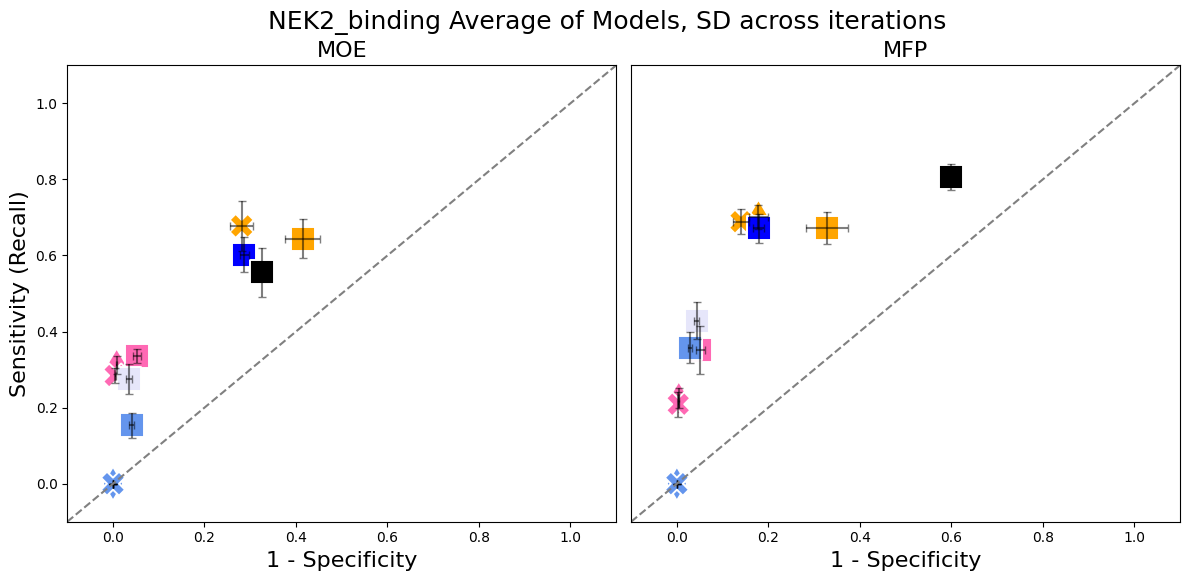

total size: (600, 21)
avg of folds for each it: (120, 5)
average of those 10 iterations: (12, 4)
then, take std of that: (12, 4)


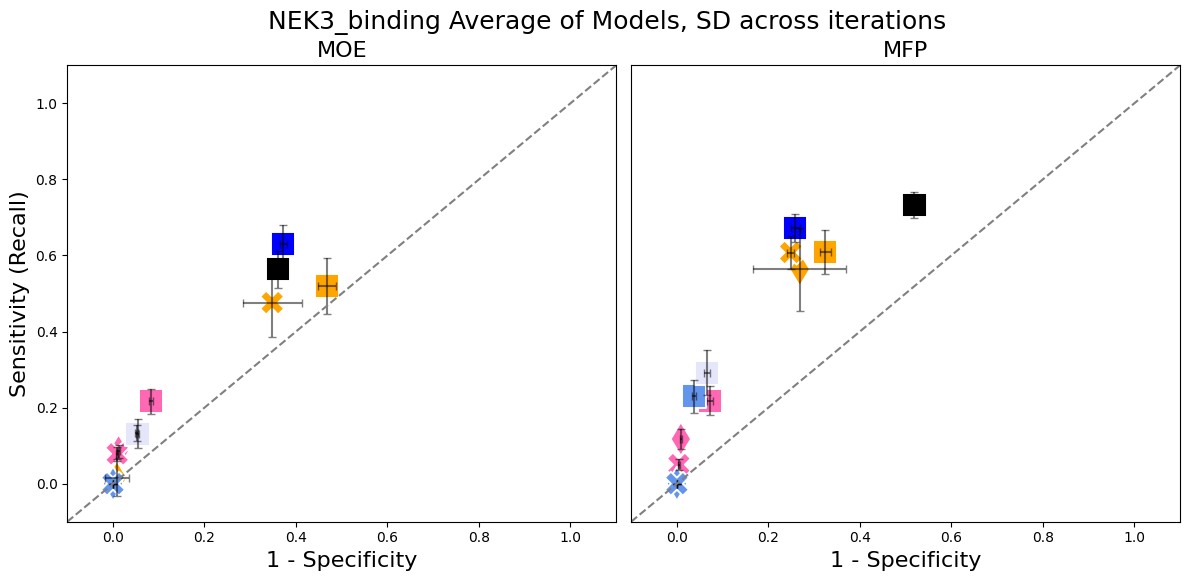

total size: (600, 21)
avg of folds for each it: (120, 5)
average of those 10 iterations: (12, 4)
then, take std of that: (12, 4)


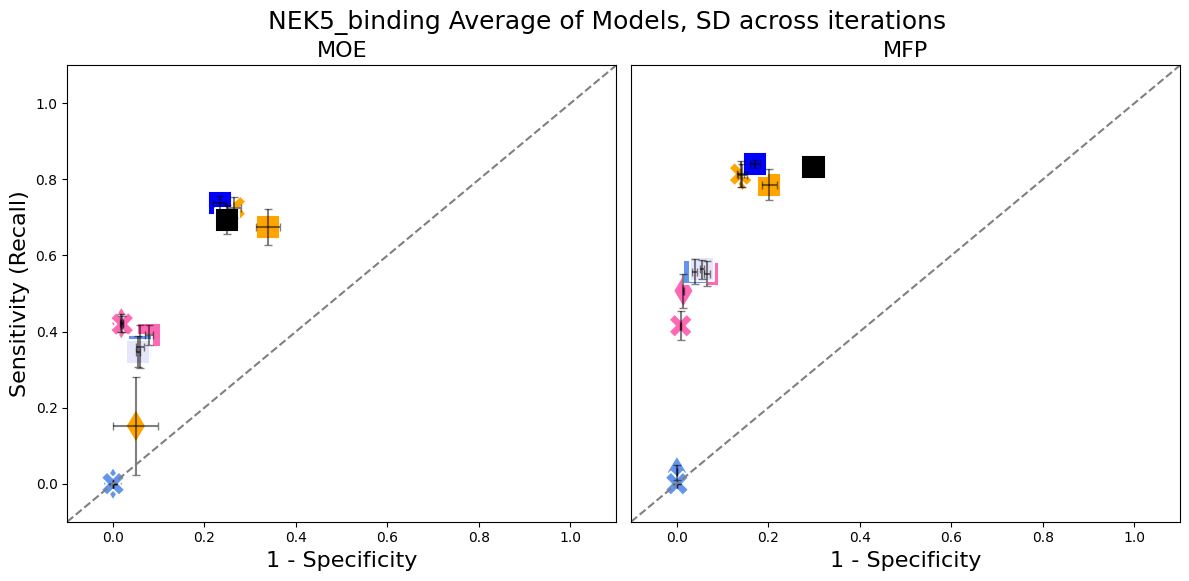

total size: (600, 21)
avg of folds for each it: (120, 5)
average of those 10 iterations: (12, 4)
then, take std of that: (12, 4)


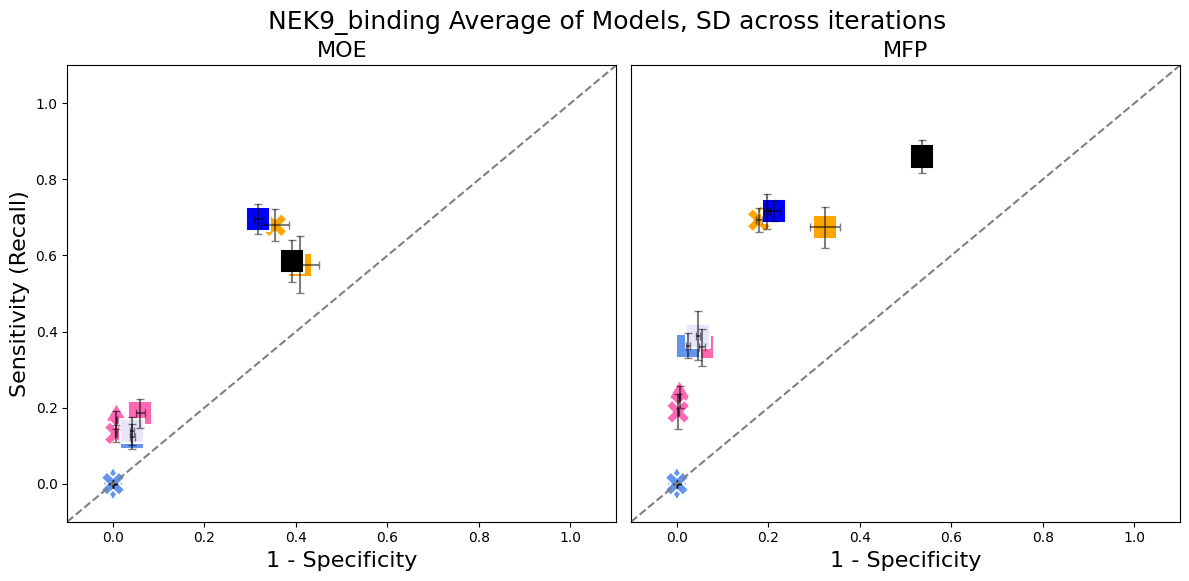

total size: (600, 21)
avg of folds for each it: (120, 5)
average of those 10 iterations: (12, 4)
then, take std of that: (12, 4)


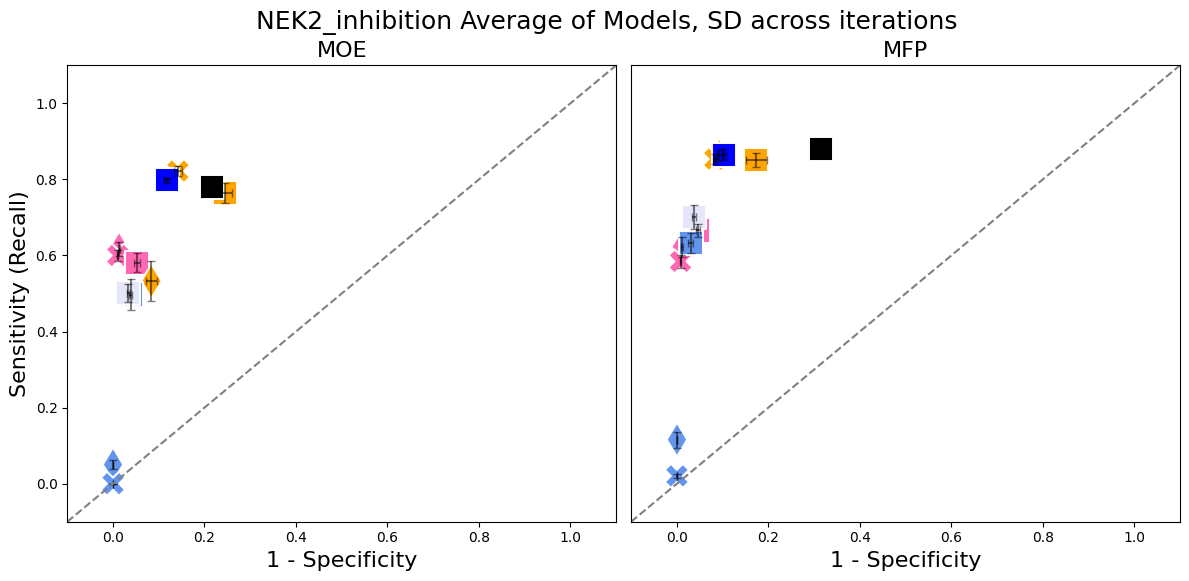

total size: (600, 21)
avg of folds for each it: (120, 5)
average of those 10 iterations: (12, 4)
then, take std of that: (12, 4)


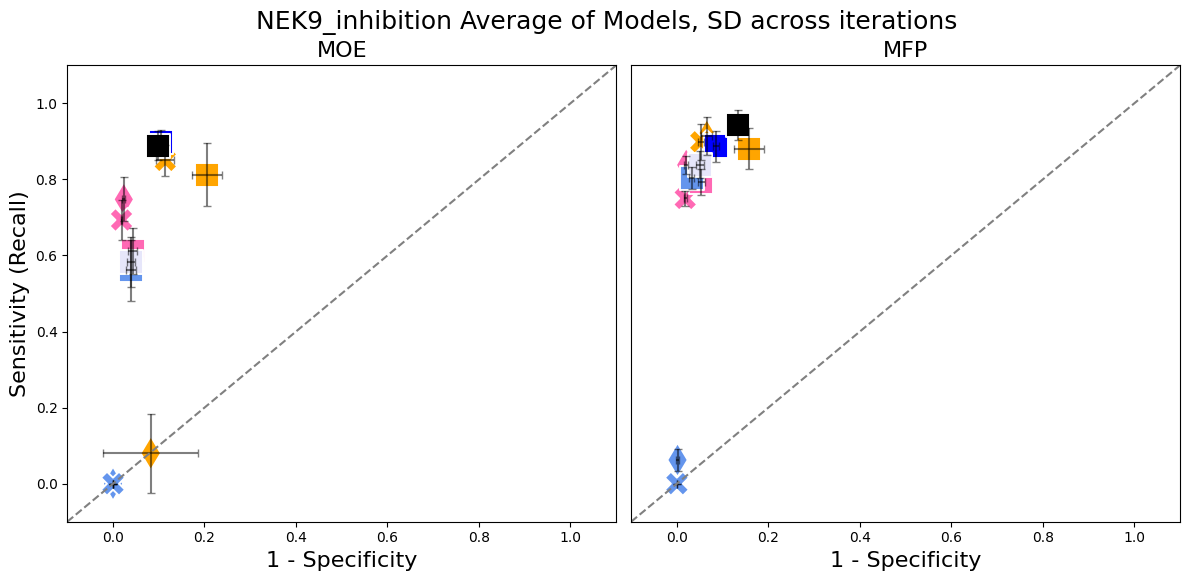

In [79]:
for nek in all_data['NEK'].unique():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    nek_df = all_data[all_data['NEK'] == nek]
    moe_df = nek_df[nek_df['feat_type'] == 'MOE']
    mfp_df = nek_df[nek_df['feat_type'] == 'MFP']
    print(f'total size: {moe_df.shape}')
    # for each it 1-10, get average of all 5 folds for that iteration (that model) 
    moe_iter_avg = moe_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    mfp_iter_avg = mfp_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    print(f'avg of folds for each it: {moe_iter_avg.shape}') 
    # average of all iterations to get std of iterations 
    moe_avg = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index() 
    moe_std = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index() # n =10 
    print(f'average of those 10 iterations: {moe_avg.shape}')
    print(f'then, take std of that: {moe_std.shape}')
    mfp_avg = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index()
    mfp_std = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index()

    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=1, ax=axs[0], legend=False, palette=samp_palette)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=1, ax=axs[1], legend=False, palette=samp_palette)

    axs[0].errorbar(x=moe_avg['1-specificity'], y=moe_avg['recall'],
                    xerr=moe_std['1-specificity'], yerr=moe_std['recall'],
                    fmt='none', ecolor='black', alpha=0.5, capsize=3)
    axs[1].errorbar(x=mfp_avg['1-specificity'], y=mfp_avg['recall'],
                    xerr=mfp_std['1-specificity'], yerr=mfp_std['recall'],
                    fmt='none', ecolor='black', alpha=0.5, capsize=3)


    plt.suptitle(f'{nek} Average of Models, SD across iterations', fontsize=18, x=0.51, y=0.96)
    axs[0].set_ylabel('Sensitivity (Recall)', fontsize=16)
    axs[1].set_ylabel('')
    axs[1].set_yticks([])
    for i, ax in enumerate(axs):
        ax.plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel('1 - Specificity', fontsize=16)
        

    axs[0].set_title(f'MOE', fontsize=16)
    axs[1].set_title(f'MFP', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles=handles, labels=labels,
    #            loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=2, fontsize=12)
    raw_RF_BCW = Line2D([0], [0], color='lavender', marker='s', markersize=15, linestyle='None', markerfacecolor='lavender', markeredgewidth=0, label='nosamp RF BalWeight')
    raw_BRFC = Line2D([0], [0], color='blue', marker='s', markersize=15, linestyle='None', markerfacecolor='blue', markeredgewidth=0, label='nosamp Bstrp Under')
    raw_BRFC_BCW = Line2D([0], [0], color='black', marker='s', markersize=15, linestyle='None', markerfacecolor='black', markeredgewidth=0, label='nosamp Bstrp Under BalWeight')
    UNDER_RF = Line2D([0], [0], color='orange', marker='s', markersize=15, linestyle='None', markerfacecolor='orange', markeredgewidth=0, label='UNDER RF')
    ADASYN_RF = Line2D([0], [0], color='tab:red', marker='s', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN RF')
    raw_RF =  Line2D([0], [0], color='cornflowerblue', marker='s', markersize=15, linestyle='None', markerfacecolor='cornflowerblue', markeredgewidth=0, label='nosamp RF')
    UNDER_GP_matern = Line2D([0],[0], color='orange', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:orange', markeredgewidth=0, label='UNDER GP matern')
    UNDER_GP_RBF = Line2D([0],[0], color='orange', marker='d', markersize=15, linestyle='None', markerfacecolor='orange', markeredgewidth=0, label='UNDER GP RBF')
    ADASYN_GP_matern = Line2D([0], [0], color='tab:red', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN GP matern')
    ADASYN_GP_RBF = Line2D([0], [0], color='tab:red', marker='d', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN GP RBF')
    SMOTE_RF = Line2D([0], [0], color='hotpink', marker='s', markersize=15, linestyle='None', markerfacecolor='hotpink', markeredgewidth=0, label='SMOTE RF')
    SMOTE_GP_matern = Line2D([0], [0], color='hotpink', marker='X', markersize=15, linestyle='None', markerfacecolor='hotpink', markeredgewidth=0, label='SMOTE GP matern')
    SMOTE_GP_RBF = Line2D([0], [0], color='hotpink', marker='d', markersize=15, linestyle='None', markerfacecolor='hotpink', markeredgewidth=0, label='SMOTE GP RBF')
    no_samp_GP_matern = Line2D([0], [0], color='tab:blue', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:blue', markeredgewidth=0, label='nosamp GP matern')
    no_samp_GP_RBF = Line2D([0], [0], color='tab:blue', marker='d', markersize=15, linestyle='None', markerfacecolor='tab:blue', markeredgewidth=0, label='nosamp GP RBF')
    err_legend = Line2D([0],[0], color='black', linestyle='-', linewidth=1.5, label='Error Bars: SD across iterations (x_err=1-spec err, y_err=sensitivity err)')

    # axs[0].legend(handles=[no_samp_GP_matern,UNDER_GP_matern, SMOTE_GP_matern,
    #              raw_RF,raw_RF_BCW,raw_BRFC, raw_BRFC_BCW, UNDER_RF,SMOTE_RF,err_legend], ncols=4, bbox_to_anchor=(.3, -.2) )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    figs1 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/it_SD/'
    # plt.savefig(f'{figs}{nek}_avg_all50x.png', bbox_inches='tight')
    # plt.savefig(f'{figs}{nek}_avg5fold_std10it.png', bbox_inches='tight')
    # plt.savefig(f'{figs1}{nek}_itSD.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# attempting SD across folds

total size: (600, 21)
moe fold avg: (60, 5)
moe fold std: (12, 4)


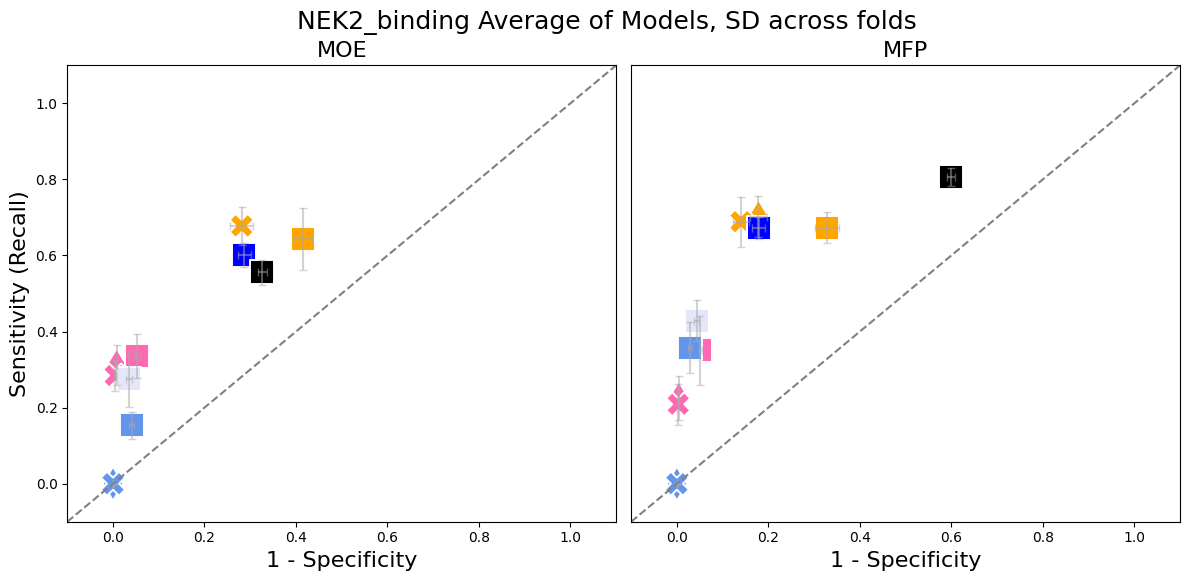

total size: (600, 21)
moe fold avg: (60, 5)
moe fold std: (12, 4)


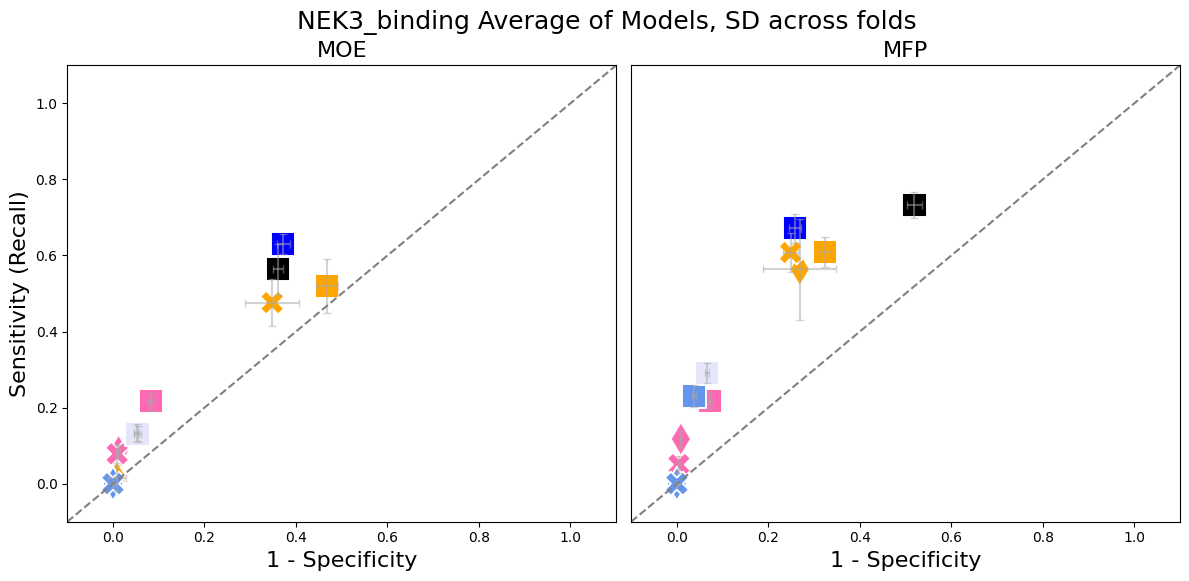

total size: (600, 21)
moe fold avg: (60, 5)
moe fold std: (12, 4)


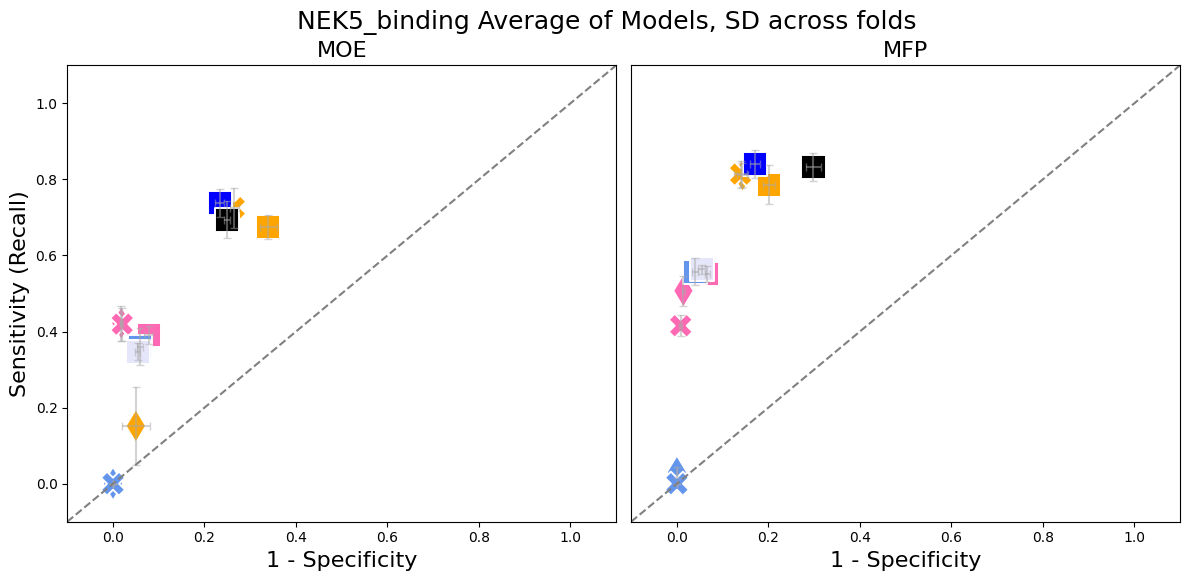

total size: (600, 21)
moe fold avg: (60, 5)
moe fold std: (12, 4)


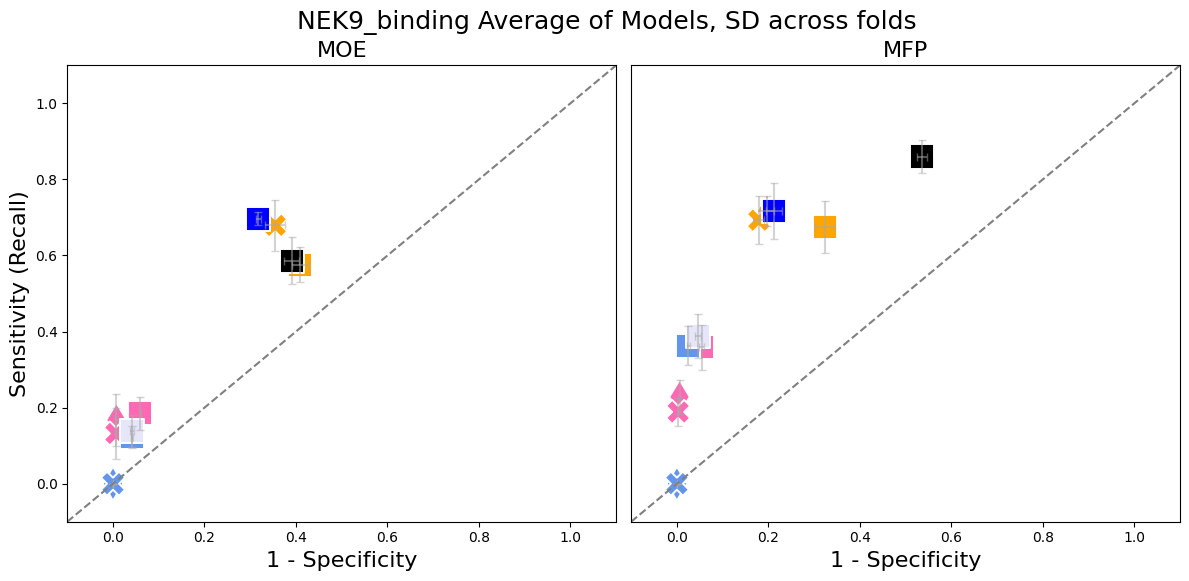

total size: (600, 21)
moe fold avg: (60, 5)
moe fold std: (12, 4)


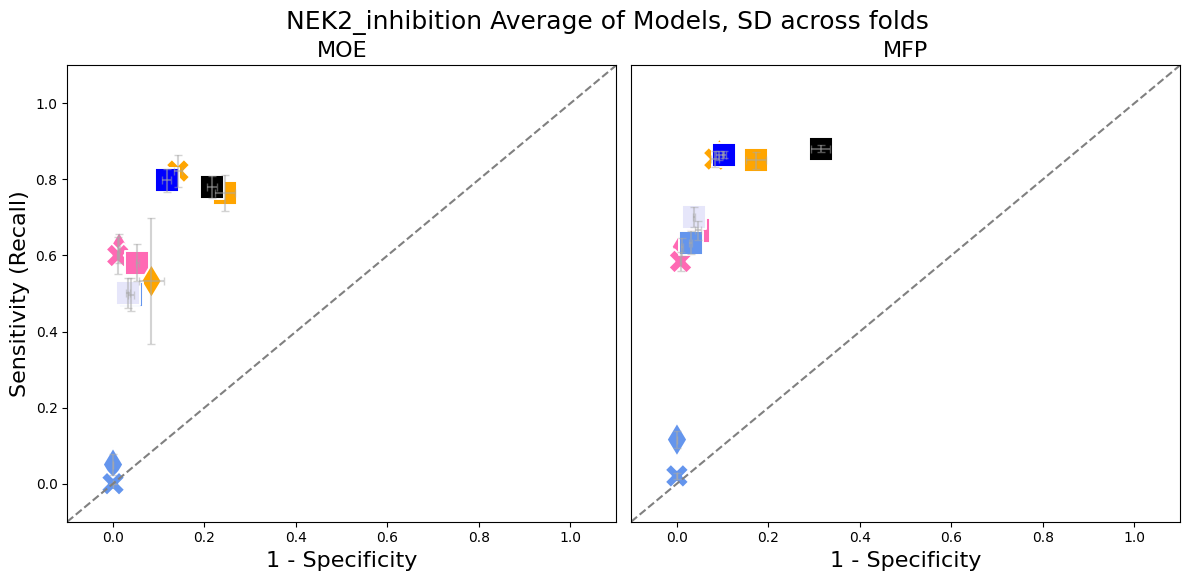

total size: (600, 21)
moe fold avg: (60, 5)
moe fold std: (12, 4)


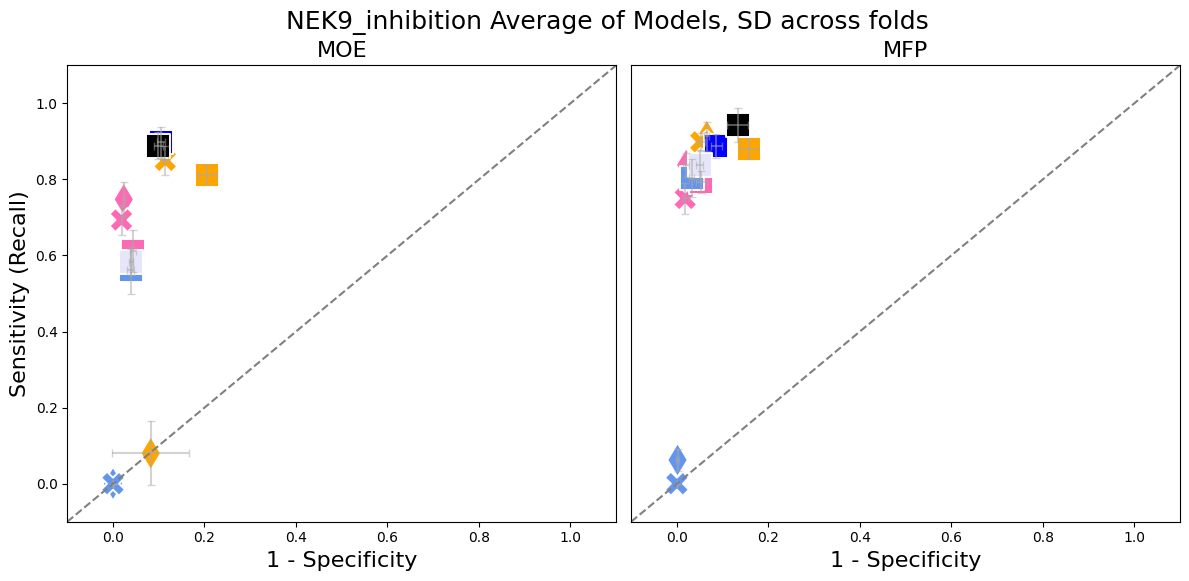

In [67]:
for nek in all_data['NEK'].unique():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    nek_df = all_data[all_data['NEK'] == nek]
    moe_df = nek_df[nek_df['feat_type'] == 'MOE']
    mfp_df = nek_df[nek_df['feat_type'] == 'MFP']
    print(f'total size: {moe_df.shape}')
    # for each it 1-10, get average of all 5 folds for that iteration (that model) 
    moe_iter_avg = moe_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    mfp_iter_avg = mfp_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()

    # average of all iterations to get std of iterations 
    moe_avg = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index() 
    moe_std = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index() # n =10 


    mfp_avg = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index()
    mfp_std = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index() 
    
    moe_fold_avg = moe_df.groupby(['strategy', 'modeling_type', 'fold'])[['recall', '1-specificity']].mean().reset_index()
    moe_fold_std = moe_fold_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index()
    print(f'moe fold avg: {moe_fold_avg.shape}')
    print(f'moe fold std: {moe_fold_std.shape}')
    mfp_fold_avg = mfp_df.groupby(['strategy', 'modeling_type', 'fold'])[['recall', '1-specificity']].mean().reset_index()
    mfp_fold_std = mfp_fold_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index()

    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=1, ax=axs[0], legend=False, palette=samp_palette)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=1, ax=axs[1], legend=False, palette=samp_palette)

    axs[0].errorbar(x=moe_avg['1-specificity'], y=moe_avg['recall'],
                    xerr=moe_fold_std['1-specificity'], yerr=moe_fold_std['recall'],
                    fmt='none', ecolor='darkgray', alpha=0.5, capsize=3)
    axs[1].errorbar(x=mfp_avg['1-specificity'], y=mfp_avg['recall'],
                    xerr=mfp_fold_std['1-specificity'], yerr=mfp_fold_std['recall'],
                    fmt='none', ecolor='darkgray', alpha=0.5, capsize=3)

    plt.suptitle(f'{nek} Average of Models, SD across folds', fontsize=18, x=0.51, y=0.96)
    axs[0].set_title(f'MOE', fontsize=16)
    axs[1].set_title(f'MFP', fontsize=16)
    axs[0].set_ylabel('Sensitivity (Recall)', fontsize=16)
    axs[1].set_ylabel('')
    axs[1].set_yticks([])
    for i, ax in enumerate(axs):
        ax.plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel('1 - Specificity', fontsize=16)


    handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles=handles, labels=labels,
    #            loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=2, fontsize=12)
    raw_RF_BCW = Line2D([0], [0], color='lavender', marker='s', markersize=15, linestyle='None', markerfacecolor='lavender', markeredgewidth=0, label='nosamp RF BalWeight')
    raw_BRFC = Line2D([0], [0], color='blue', marker='s', markersize=15, linestyle='None', markerfacecolor='blue', markeredgewidth=0, label='nosamp Bstrp Under')
    raw_BRFC_BCW = Line2D([0], [0], color='black', marker='s', markersize=15, linestyle='None', markerfacecolor='black', markeredgewidth=0, label='nosamp Bstrp Under BalWeight')
    UNDER_RF = Line2D([0], [0], color='orange', marker='s', markersize=15, linestyle='None', markerfacecolor='orange', markeredgewidth=0, label='UNDER RF')
    ADASYN_RF = Line2D([0], [0], color='tab:red', marker='s', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN RF')
    raw_RF =  Line2D([0], [0], color='cornflowerblue', marker='s', markersize=15, linestyle='None', markerfacecolor='cornflowerblue', markeredgewidth=0, label='nosamp RF')
    UNDER_GP_matern = Line2D([0],[0], color='orange', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:orange', markeredgewidth=0, label='UNDER GP matern')
    UNDER_GP_RBF = Line2D([0],[0], color='orange', marker='d', markersize=11, linestyle='None', markerfacecolor='orange', markeredgewidth=0, label='UNDER GP RBF')
    ADASYN_GP_matern = Line2D([0], [0], color='tab:red', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN GP matern')
    ADASYN_GP_RBF = Line2D([0], [0], color='tab:red', marker='d', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN GP RBF')
    SMOTE_RF = Line2D([0], [0], color='hotpink', marker='s', markersize=15, linestyle='None', markerfacecolor='hotpink', markeredgewidth=0, label='SMOTE RF')
    SMOTE_GP_matern = Line2D([0], [0], color='hotpink', marker='X', markersize=15, linestyle='None', markerfacecolor='hotpink', markeredgewidth=0, label='SMOTE GP matern')
    SMOTE_GP_RBF = Line2D([0], [0], color='hotpink', marker='d', markersize=11, linestyle='None', markerfacecolor='hotpink', markeredgewidth=0, label='SMOTE GP RBF')
    no_samp_GP_matern = Line2D([0], [0], color='tab:blue', marker='X', markersize=15, linestyle='None', markerfacecolor='tab:blue', markeredgewidth=0, label='nosamp GP matern')
    no_samp_GP_RBF = Line2D([0], [0], color='tab:blue', marker='d', markersize=11, linestyle='None', markerfacecolor='tab:blue', markeredgewidth=0, label='nosamp GP RBF')
    err_legend = Line2D([0],[0], color='gray', linestyle='-', linewidth=1.5, label='Error Bars: SD across folds (x_err=1-spec err, y_err=sensitivity err)')

    # axs[0].legend(handles=[no_samp_GP_matern, no_samp_GP_RBF,UNDER_GP_matern, UNDER_GP_RBF, SMOTE_GP_matern, SMOTE_GP_RBF,
    #              raw_RF,raw_RF_BCW,raw_BRFC, raw_BRFC_BCW, UNDER_RF,SMOTE_RF,err_legend], ncols=4,bbox_to_anchor=(.3, -.2))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    figs2 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/fold_SD/'
    # plt.savefig(f'{figs2}{nek}_foldSD.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# make a table of model results SD, mean 

In [128]:

rf_kfold_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_kfold_results/'
rf_kfold_results1 = pd.read_csv(f'{rf_kfold_path}repeated0-5_RF_test_results_all_NEK_kfold_val_5x.csv')
rf_kfold_results2 = pd.read_csv(f'{rf_kfold_path}RF_test_results_all_NEK_kfold_val_5x_6-10.csv')
rf_kfold_results2['iteration'] = rf_kfold_results2['iteration']+5

rf_kfold_nersc = pd.concat([rf_kfold_results1, rf_kfold_results2])

gp = pd.read_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val_10x.csv')
rf_kfold_nersc=rf_kfold_nersc.rename(columns={'RF_type': 'params'})
rf_kfold_nersc['modeling_type']='RF'

rf_raw = rf_kfold_nersc[(rf_kfold_nersc['strategy'] == 'none_scaled') & (rf_kfold_nersc['params'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf_kfold_nersc[(rf_kfold_nersc['params'] == 'RF') & (rf_kfold_nersc['strategy'].isin(['UNDER', 'SMOTE', 'ADASYN']))]  
rfs=pd.concat([rf_raw, rf_other])

gp=gp.rename(columns={'kernel_type':'params'}) 
gp['modeling_type']='GP'

kfold_data = pd.concat([rfs, gp])
kfold_data
keep_columns = ['NEK', 'strategy', 'feat_type', 'params', 'modeling_type','recall', 'specificity', 'balanced_accuracy', 'fold', 'iteration']
kfold_data= kfold_data[keep_columns]

kfold_data['strategy']=kfold_data['strategy'].replace('none_scaled', 'Orig')
kfold_data=kfold_data[kfold_data['strategy']!='ADASYN']
kfold_data['params'].value_counts()
kfold_data['1-specificity']=1-kfold_data['specificity']

iter_avg = kfold_data.groupby(['NEK', 'feat_type','strategy', 'params', 'modeling_type','iteration'])[['recall', 'specificity','1-specificity', 'balanced_accuracy']].mean().reset_index()
iter_std = iter_avg.groupby(['NEK', 'feat_type','strategy', 'params', 'modeling_type'])[['recall', 'specificity','1-specificity', 'balanced_accuracy']].std().reset_index()


all_avg = iter_avg.groupby(['NEK','feat_type','strategy','params', 'modeling_type'])[['recall', 'specificity','1-specificity', 'balanced_accuracy']].mean().reset_index() 
all_std = iter_avg.groupby(['NEK','feat_type','strategy','params', 'modeling_type'])[['recall', 'specificity','1-specificity', 'balanced_accuracy']].std().reset_index() # n =10 


fold_avg = kfold_data.groupby(['NEK', 'feat_type','strategy', 'params','modeling_type','fold'])[['recall', 'specificity','1-specificity', 'balanced_accuracy']].mean().reset_index()
fold_std=fold_avg.groupby(['NEK', 'feat_type','strategy', 'params','modeling_type'])[['recall', 'specificity','1-specificity', 'balanced_accuracy']].std().reset_index()


dfs = [iter_avg,iter_std,all_avg,all_std,fold_avg,fold_std]
df_names = ['iter_avg','iter_std','all_avg','all_std','fold_avg','fold_std']
for df, df_name in zip(dfs, df_names): 
    df['model_name'] = df['NEK'].astype(str)+'_'+['feat_type']+'_'+df['strategy']+'_'+df['params']
    print(df.shape)
    df.shape
    df.to_csv(f'gen_kfold/{df_name}.csv',index=False)

(1440, 11)
(144, 10)
(144, 10)
(144, 10)
(720, 11)
(144, 10)


In [133]:
df

NEK feat_type strategy     params modeling_type    recall  \
0       NEK2_binding       MFP     Orig       BRFC            RF  0.028974   
1       NEK2_binding       MFP     Orig   BRFC_BCW            RF  0.023040   
2       NEK2_binding       MFP     Orig     GP_RBF            GP  0.000000   
3       NEK2_binding       MFP     Orig  GP_matern            GP  0.000000   
4       NEK2_binding       MFP     Orig         RF            RF  0.067312   
..               ...       ...      ...        ...           ...       ...   
139  NEK9_inhibition       MOE    SMOTE  GP_matern            GP  0.039641   
140  NEK9_inhibition       MOE    SMOTE         RF            RF  0.055108   
141  NEK9_inhibition       MOE    UNDER     GP_RBF            GP  0.083666   
142  NEK9_inhibition       MOE    UNDER  GP_matern            GP  0.039051   
143  NEK9_inhibition       MOE    UNDER         RF            RF  0.023905   

     specificity  1-specificity  balanced_accuracy  \
0       0.014680       0.014680           0.013375   
1       0.008603       0.008603           0.009688   
2       0.000000       0.000000           0.000000   
3       0.000000       0.000000           0.000000   
4       0.004613       0.004613           0.032803   
..           ...            ...                ...   
139     0.002036       0.002036           0.019116   
140     0.006313       0.006313           0.029803   
141     0.084434       0.084434           0.001018   
142     0.006682       0.006682           0.019043   
143     0.020962       0.020962           0.020598   

                                    model_name  
0             NEK2_binding_feat_type_Orig_BRFC  
1         NEK2_binding_feat_type_Orig_BRFC_BCW  
2           NEK2_binding_feat_type_Orig_GP_RBF  
3        NEK2_binding_feat_type_Orig_GP_matern  
4               NEK2_binding_feat_type_Orig_RF  
..                                         ...  
139  NEK9_inhibition_feat_type_SMOTE_GP_matern  
140         NEK9_inhibition_feat_type_SMOTE_RF  
141     NEK9_inhibition_feat_type_UNDER_GP_RBF  
142  NEK9_inhibition_feat_type_UNDER_GP_matern  
143         NEK9_inhibition_feat_type_UNDER_RF  

[144 rows x 10 columns]

In [113]:
3 # SMOTE, UNDER, Orig = RF 
print(f'RF {3*2*6*50}')
print(f'other RF/BRFC: {1*3*2*6*50/3}')
# GP
print(f'GP: {3*2*6*50}') 

RF 1800
other RF/BRFC: 600.0
GP: 1800


In [136]:
2*2*6*3 # divide by 2 because GP matern only
3*2*6  # default RF 
3*2*6
36+36+72

144

In [154]:
### SD across iteraions 
iter_avg = all_data.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity','balanced_accuracy']].mean().reset_index()

# average of all iterations to get std of iterations 
avg_df = iter_avg.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity','balanced_accuracy']].mean().reset_index() #50x 
std_df = iter_avg.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity','balanced_accuracy']].std().reset_index() #50x 

final_df = avg_df.merge(std_df, on=['NEK', 'feat_type', 'strategy', 'modeling_type'], suffixes=('_iter_mean', '_iter_sd'))

print(f'std df shape {std_df.shape}')
print(f'after merge {final_df.shape}')
### SD across folds ### 
# mean recall and 1-specificity across folds for each it
iter_avg2 = all_data.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity','balanced_accuracy']].mean().reset_index()

# mean and standard deviation across iterations (n=10)
avg_df2 = iter_avg2.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity','balanced_accuracy']].mean().reset_index()

# compute mean and sd across folds (n=5)
fold_avg = all_data.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type', 'fold'])[['recall', '1-specificity','balanced_accuracy']].mean().reset_index()
fold_std = fold_avg.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity','balanced_accuracy']].std().reset_index()

# Merge iteration stats and fold stats
final_df2 = avg_df2.merge(fold_std, on=['NEK', 'feat_type', 'strategy', 'modeling_type'], suffixes=('_fold_mean', '_fold_sd'))


final_df_all = final_df.merge(final_df2, on=['NEK','feat_type', 'strategy', 'modeling_type'])
print(f'fold std shape {fold_std.shape}')
print(f'after merge {final_df2.shape}')
print(f'antoher merge? {final_df_all.shape}')
final_df_all=final_df_all[final_df_all['modeling_type']!='GP_RBF']
print(f'antoher merge? {final_df_all.shape}')
merged_50x = avg_df.merge(std_df, on=['NEK', 'feat_type', 'strategy', 'modeling_type'], suffixes=('_50x_mean', '_50x_sd'))
merged_50x

merged_50x=merged_50x[merged_50x['modeling_type']!='GP_RBF']
all_merged = final_df_all.merge(merged_50x, on=['NEK', 'feat_type', 'strategy', 'modeling_type'])
all_merged
all_merged.to_csv('gen_kfold/kfold_avg_it_fold_all.csv',index=False)

# final_df_all['model'] = final_df_all['strategy'].astype(str)+'_'+final_df_all['feat_type'] 
# final_df_all['model2'] =final_df_all['NEK'].astype(str)+'_'+ final_df_all['strategy']+'_'+final_df_all['feat_type'] 
# display(final_df_all)

# final_df_all.to_csv('gen_kfold/other_combo_metrics_mean_std.csv',index=False)

# final_df_all=final_df_all.drop(columns=['feat_type','modeling_type'])
# final_df_all=final_df_all.drop(columns=['1-specificity_fold_mean','recall_fold_mean','balanced_accuracy_fold_mean','balanced_accuracy_fold_sd', 'balanced_accuracy_iter_sd'])
# simple_cols = {'recall_iter_mean': 'recall_mean', '1-specificity_iter_mean': '1-specificity_mean', 'balanced_accuracy_iter_mean': 'balanced_accuracy_mean'} 
# final_df_all=final_df_all.rename(columns=simple_cols)


std df shape (144, 7)
after merge (144, 10)
fold std shape (144, 7)
after merge (144, 10)
antoher merge? (144, 16)
antoher merge? (108, 16)


NEK feat_type               strategy modeling_type  \
1       NEK2_binding       MFP        SMOTE_GP_matern     GP_matern   
2       NEK2_binding       MFP               SMOTE_RF            RF   
4       NEK2_binding       MFP        UNDER_GP_matern     GP_matern   
5       NEK2_binding       MFP               UNDER_RF            RF   
6       NEK2_binding       MFP       no_sampling_BRFC            RF   
..               ...       ...                    ...           ...   
138  NEK9_inhibition       MOE       no_sampling_BRFC            RF   
139  NEK9_inhibition       MOE   no_sampling_BRFC_BCW            RF   
141  NEK9_inhibition       MOE  no_sampling_GP_matern     GP_matern   
142  NEK9_inhibition       MOE         no_sampling_RF            RF   
143  NEK9_inhibition       MOE     no_sampling_RF_BCW            RF   

     recall_50x_mean  1-specificity_50x_mean  balanced_accuracy_50x_mean  \
1           0.208889                0.002963                    0.602963   
2           0.351111                0.051574                    0.649769   
4           0.688889                0.140278                    0.774306   
5           0.673333                0.328704                    0.672315   
6           0.671111                0.178704                    0.746204   
..               ...                     ...                         ...   
138         0.897619                0.104643                    0.896488   
139         0.889048                0.098929                    0.895060   
141         0.000000                0.000000                    0.500000   
142         0.561429                0.038571                    0.761429   
143         0.582857                0.039286                    0.771786   

     recall_50x_sd  1-specificity_50x_sd  balanced_accuracy_50x_sd  
1         0.033457              0.000586                  0.016758  
2         0.062679              0.009280                  0.033241  
4         0.033127              0.016822                  0.017236  
5         0.041968              0.045501                  0.024730  
6         0.038915              0.011606                  0.023416  
..             ...                   ...                       ...  
138       0.032781              0.013262                  0.018350  
139       0.038949              0.008083                  0.019982  
141       0.000000              0.000000                  0.000000  
142       0.080043              0.010754                  0.037167  
143       0.065991              0.009221                  0.034459  

[108 rows x 10 columns]

In [132]:
######### best mean BALANCED ACCURACY ###########
kfold_results = pd.read_csv('kfold_mean_SD.csv')

kfold_results.sort_values('balanced_accuracy_mean', ascending=False)

best_mean_bas = [] 
for nek in neks: 
    nek_df =final_df_all[final_df_all['NEK']==nek] 
    nek_df=nek_df.sort_values('balanced_accuracy_mean', ascending=False)
    nek_df=nek_df[(nek_df['strategy']!='UNDER_GP_matern') | (nek_df['strategy']!='UNDER_GP_matern')]
    top_ba = nek_df.sort_values('balanced_accuracy_mean', ascending=False).head(1)
    best_mean_bas.append(top_ba['model2'])
    print(top_ba['model2'])


6    NEK2_binding_no_sampling_BRFC_MFP
Name: model2, dtype: object
30    NEK2_inhibition_no_sampling_BRFC_MFP
Name: model2, dtype: object
54    NEK3_binding_no_sampling_BRFC_MFP
Name: model2, dtype: object
78    NEK5_binding_no_sampling_BRFC_MFP
Name: model2, dtype: object
102    NEK9_binding_no_sampling_BRFC_MFP
Name: model2, dtype: object
127    NEK9_inhibition_no_sampling_BRFC_BCW_MFP
Name: model2, dtype: object


In [ ]:
for nek in all_data['NEK'].unique():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    nek_df = all_data[all_data['NEK'] == nek]
    moe_df = nek_df[nek_df['feat_type'] == 'MOE']
    mfp_df = nek_df[nek_df['feat_type'] == 'MFP']
    print(f'total size: {moe_df.shape}')
    # for each it 1-10, get average of all 5 folds for that iteration (that model) 
    moe_iter_avg = moe_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    mfp_iter_avg = mfp_df.groupby(['strategy', 'modeling_type', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    print(f'avg of folds for each it: {moe_iter_avg.shape}') 
    # average of all iterations to get std of iterations 
    moe_avg = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index() 
    moe_std = moe_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index() # n =10 
    print(f'average of those 10 iterations: {moe_avg.shape}')
    print(f'then, take std of that: {moe_std.shape}')
    mfp_avg = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index()
    mfp_std = mfp_iter_avg.groupby(['strategy', 'modeling_type'])[['recall', '1-specificity']].std().reset_index()

    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=0.75, ax=axs[0], legend=False, palette=samp_palette)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=model_types_dict, s=300, alpha=0.75, ax=axs[1], legend=False, palette=samp_palette)

    axs[0].errorbar(x=moe_avg['1-specificity'], y=moe_avg['recall'],
                    xerr=moe_std['1-specificity'], yerr=moe_std['recall'],
                    fmt='none', ecolor='lightgray', alpha=0.5, capsize=3)
    axs[1].errorbar(x=mfp_avg['1-specificity'], y=mfp_avg['recall'],
                    xerr=mfp_std['1-specificity'], yerr=mfp_std['recall'],
                    fmt='none', ecolor='lightgray', alpha=0.5, capsize=3)


    plt.suptitle(f'{nek} Average of all 5 folds and 10 iterations', fontsize=18, x=0.51, y=0.96)
    for i, ax in enumerate(axs):
        ax.plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlabel('1 - Specificity', fontsize=16)
        ax.set_ylabel('Sensitivity (Recall)', fontsize=16)

    axs[0].set_title(f'{nek} MOE', fontsize=16)
    axs[1].set_title(f'{nek} MFP', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(f'{figs}{nek}_avg_all50x.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

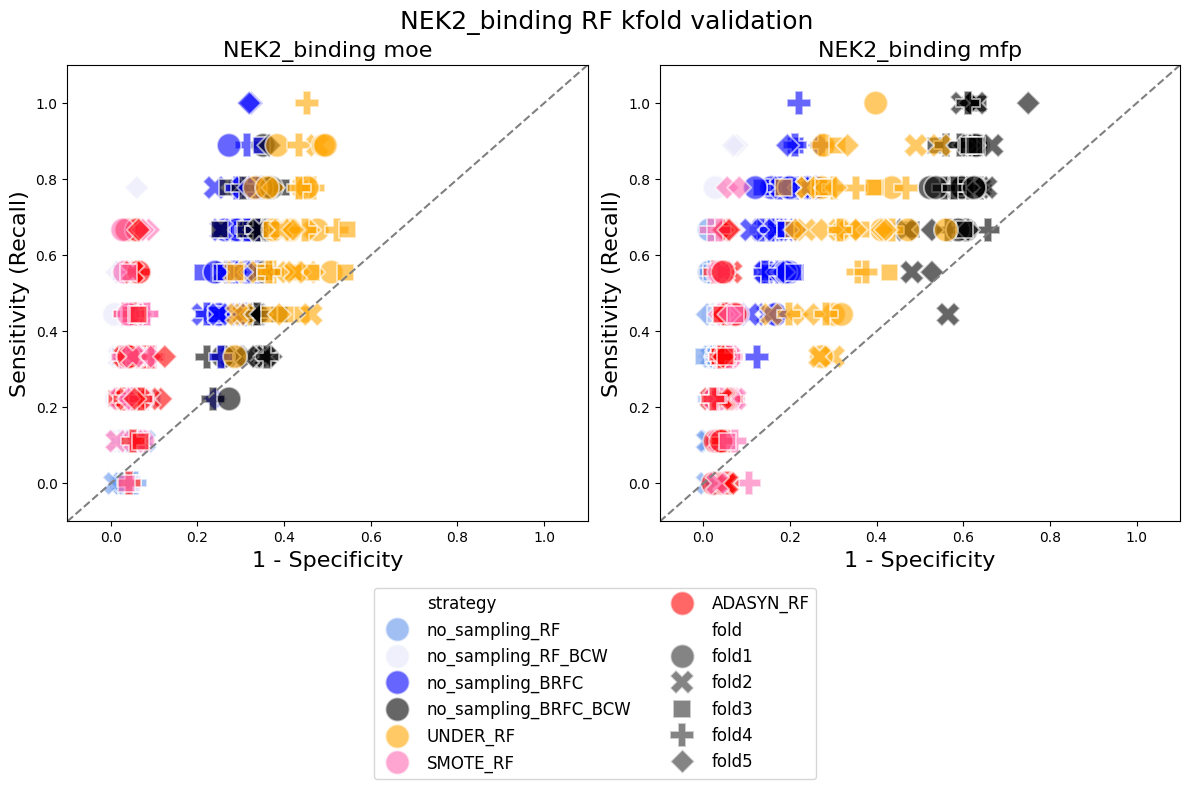

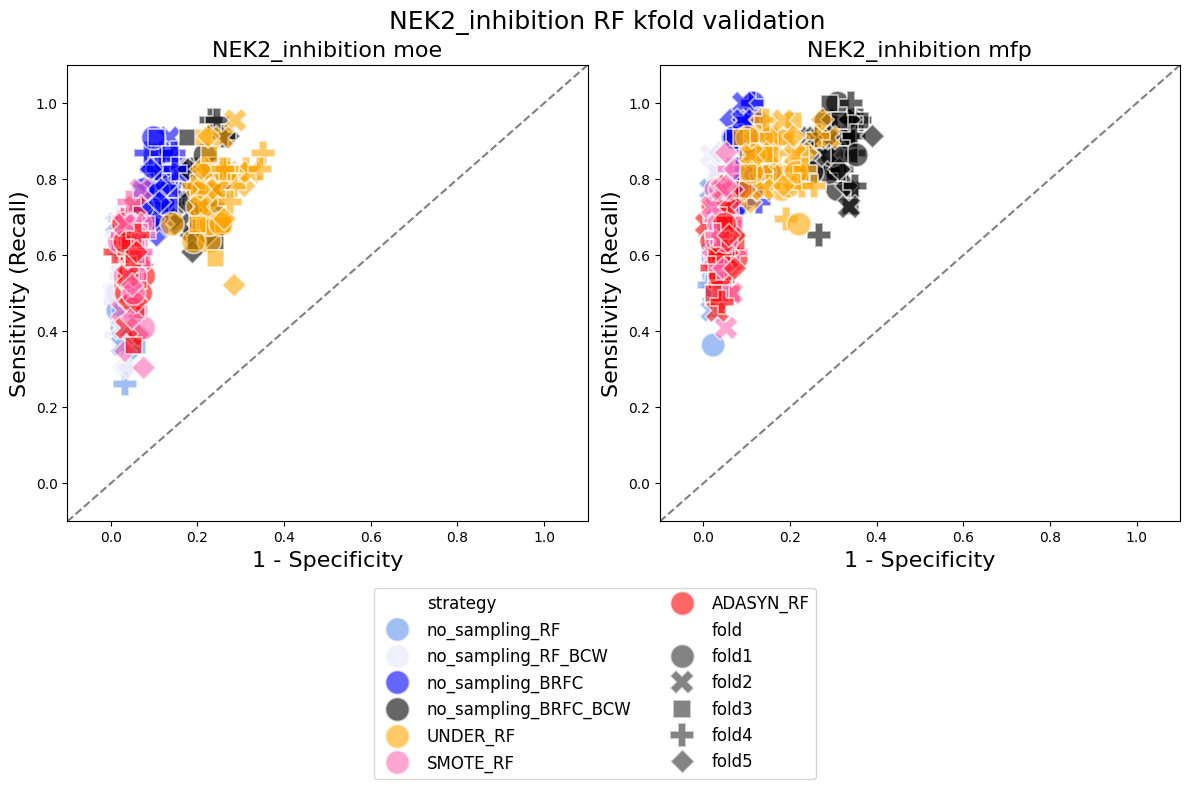

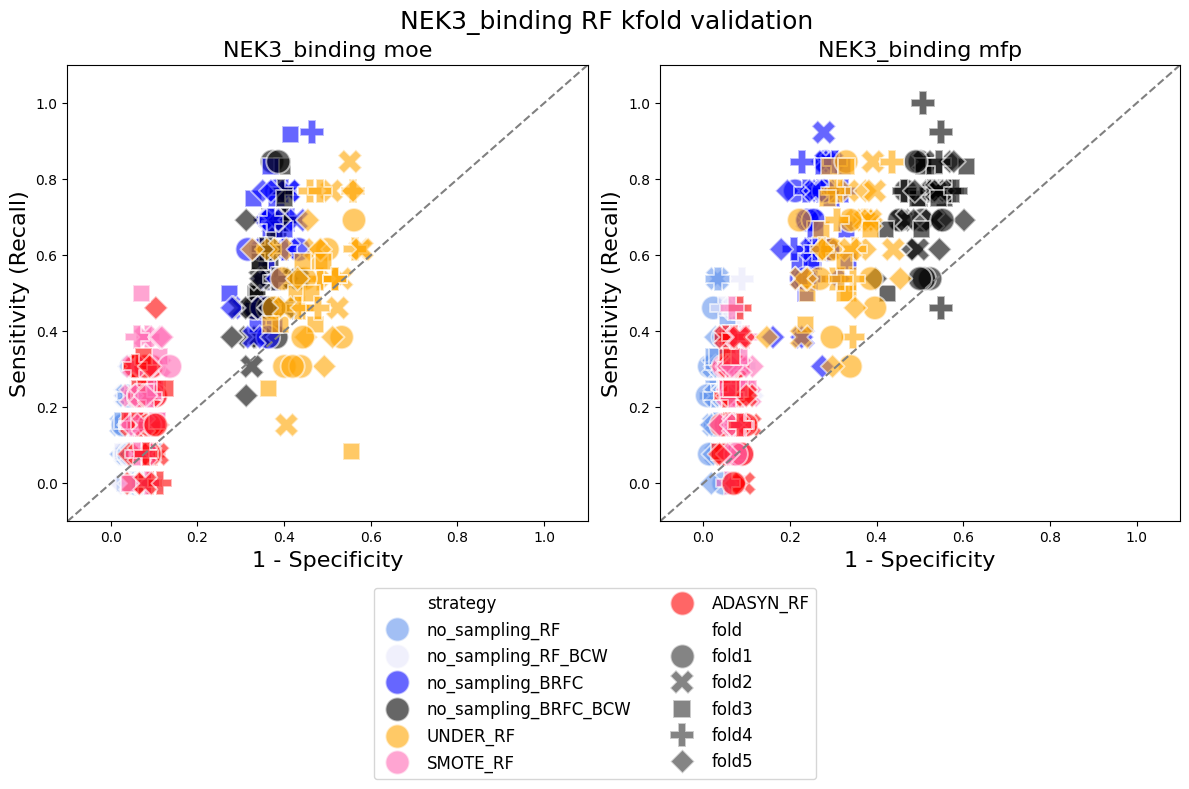

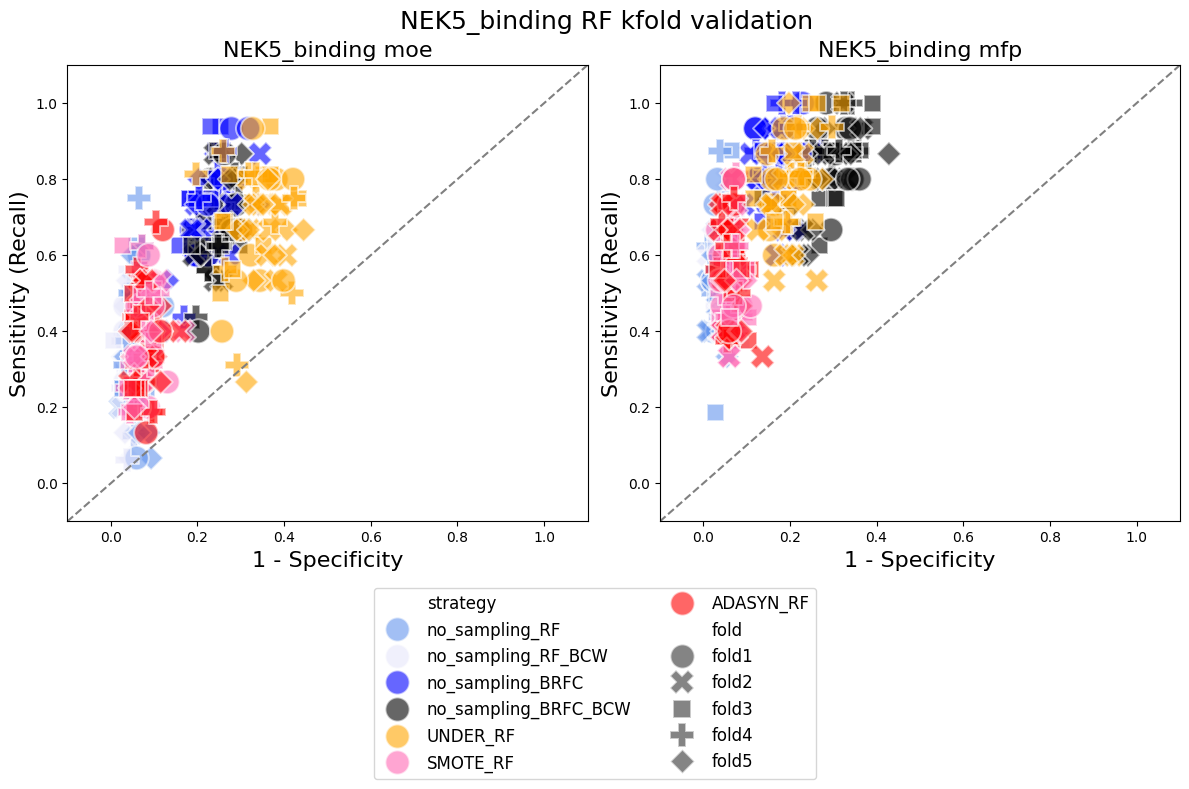

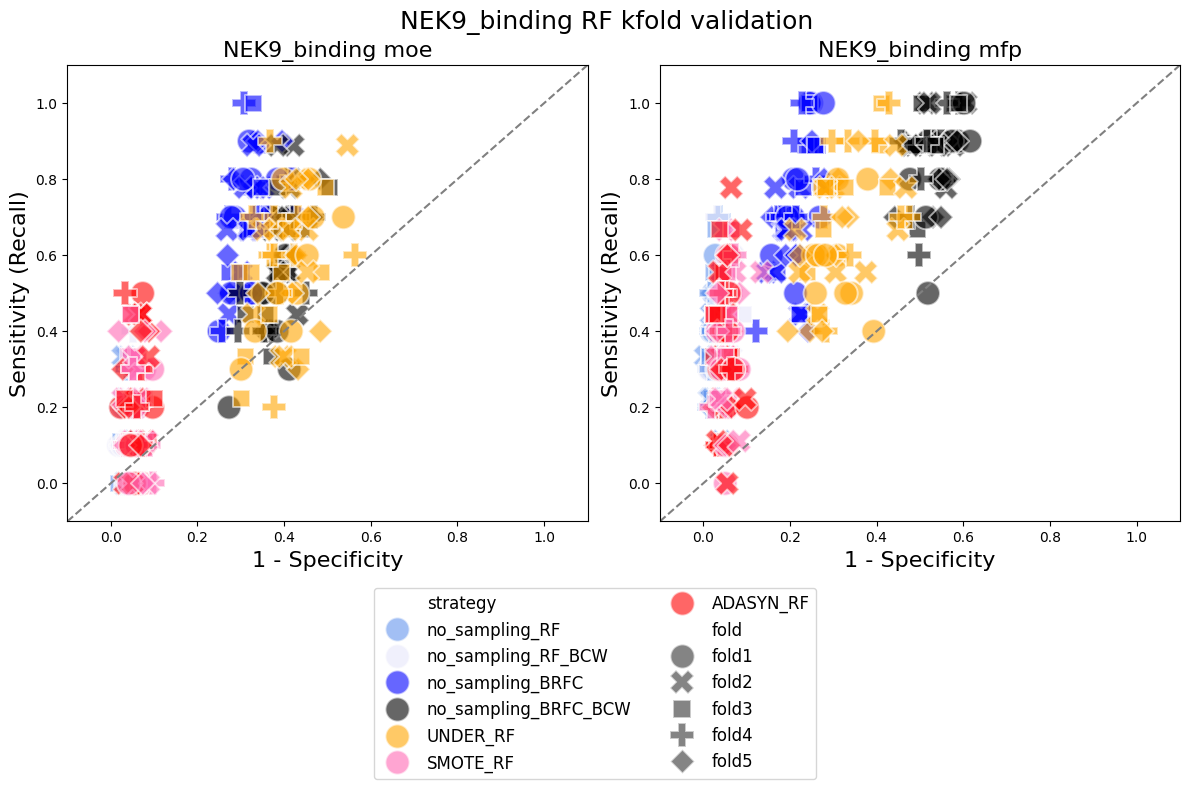

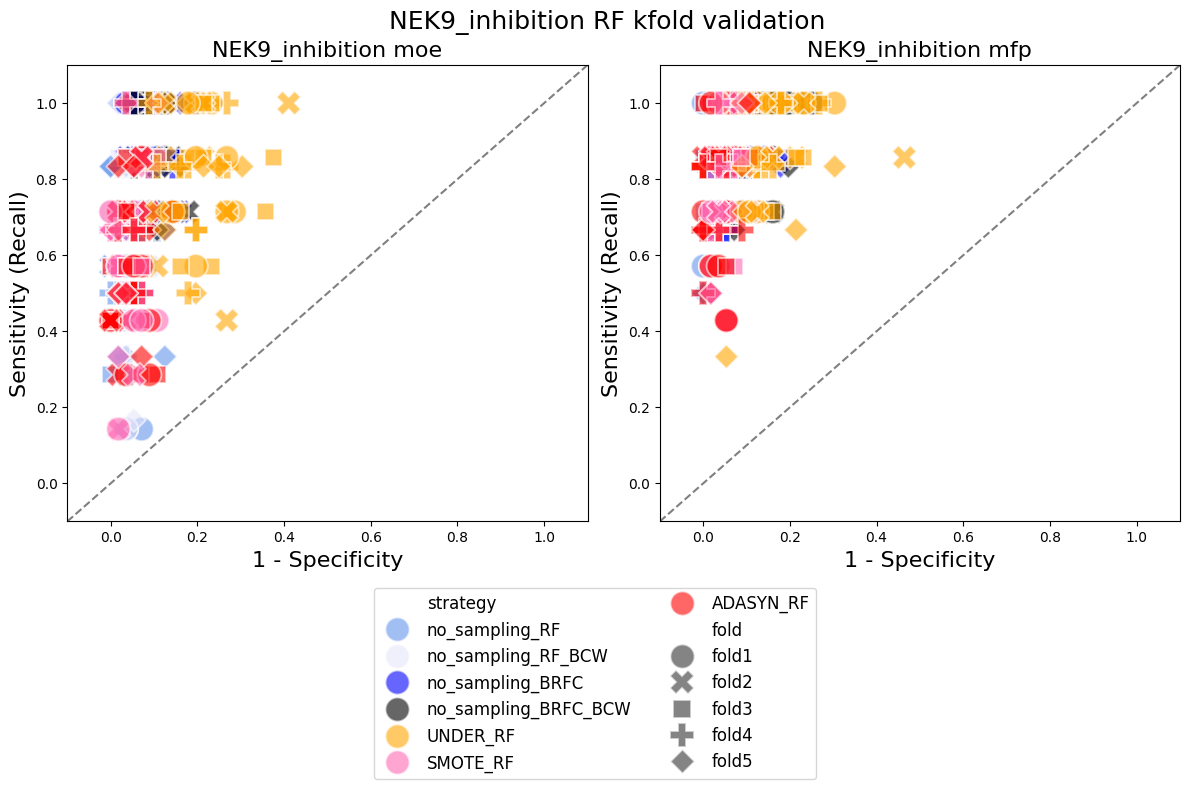

In [59]:
figs='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/rf_models/kfold_figs/'
for nek in total_rf['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = total_rf[total_rf['NEK']==nek]
    
    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} RF kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{figs}{nek}_RF_kfold.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

In [18]:
binding['strategy'].value_counts()

strategy
no_sampling_RF           400
no_sampling_RF_BCW       400
no_sampling_BRFC         400
no_sampling_BRFC_BCW     400
UNDER_RF                 400
SMOTE_RF                 400
no_sampling_GP_RBF       400
no_sampling_GP_matern    400
UNDER_GP_RBF             400
UNDER_GP_matern          400
SMOTE_GP_RBF             400
SMOTE_GP_matern          400
Name: count, dtype: int64

In [39]:
model_types_dict = {'RF':'s', 'GP_RBF': 'd', 'GP_matern':'X' }


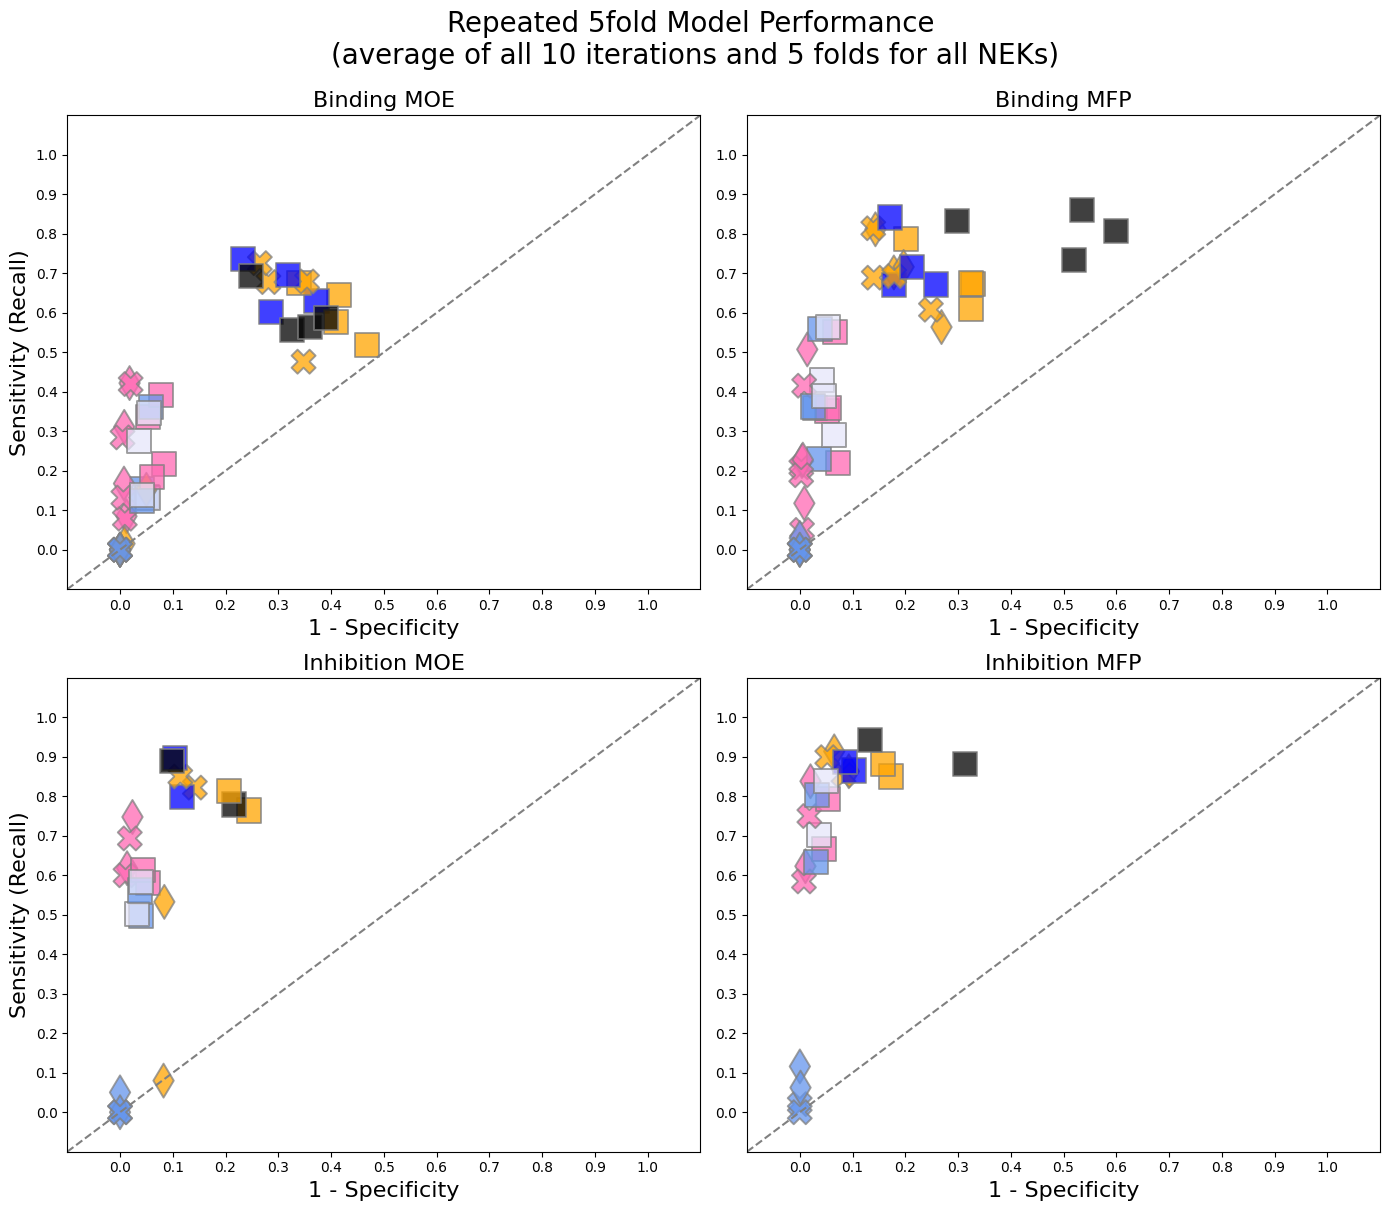

In [64]:
figs2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/gen_kfold/'
fig, axs = plt.subplots(2,2, figsize=(14,12))

for i, this_df in enumerate(list([binding, inhib])): 
    this_df = this_df[this_df['strategy']!='ADASYN']
    
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    moe_avg = moe_df.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index()
    mfp_avg = mfp_df.groupby(['NEK', 'feat_type', 'strategy', 'modeling_type'])[['recall', '1-specificity']].mean().reset_index()

    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
                   alpha=0.75,s=300, edgecolor='gray', ax=axs[i,0], palette=samp_palette,legend=False)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
                   alpha=0.75, s=300,ax=axs[i,1],edgecolor='gray', palette=samp_palette,legend=False)
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[j,0].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[j,1].set_ylabel('')
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        
        # axs[i, j].legend_.remove()
    
    axs[0, 0].set_title(f'Binding MOE', fontsize=16)
    axs[0, 1].set_title(f'Binding MFP', fontsize=16)
    axs[1, 0].set_title(f'Inhibition MOE', fontsize=16)
    axs[1, 1].set_title(f'Inhibition MFP', fontsize=16)
    # handles, labels = axs[0].get_legend_handles_labels()

    raw_RF_BCW = Line2D([0], [0], color='lavender', marker='s', markersize=15, linestyle='None', markerfacecolor='lavender', markeredgecolor='gray', markeredgewidth=1, label='Orig RF BalWeight')
    raw_BRFC = Line2D([0], [0], color='blue', marker='s', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='blue',label='Orig Bstrp Under RF')
    raw_BRFC_BCW = Line2D([0], [0], color='black', marker='s', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='black',  label='Orig Bstrp Under RF BalWeight')
    UNDER_RF = Line2D([0], [0], color='orange', marker='s', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='orange', label='UNDER RF')
    ADASYN_RF = Line2D([0], [0], color='tab:red', marker='s', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='tab:red',  label='ADASYN RF')
    raw_RF =  Line2D([0], [0], color='cornflowerblue', marker='s', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='cornflowerblue', label='Orig RF')
    UNDER_GP_matern = Line2D([0],[0], color='orange', marker='X', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='tab:orange', label='UNDER GP matern')
    UNDER_GP_RBF = Line2D([0],[0], color='orange', marker='d', markeredgecolor='gray', markeredgewidth=1,markersize=11, linestyle='None', markerfacecolor='orange', label='UNDER GP RBF')
    ADASYN_GP_matern = Line2D([0], [0], color='tab:red', marker='X', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='tab:red', label='ADASYN GP matern')
    ADASYN_GP_RBF = Line2D([0], [0], color='tab:red', marker='d', markeredgecolor='gray', markeredgewidth=1,markersize=15, linestyle='None', markerfacecolor='tab:red', label='ADASYN GP RBF')
    SMOTE_RF = Line2D([0], [0], color='hotpink', marker='s',markeredgecolor='gray', markeredgewidth=1, markersize=15, linestyle='None', markerfacecolor='hotpink', label='SMOTE RF')
    SMOTE_GP_matern = Line2D([0], [0], color='hotpink', marker='X',markeredgecolor='gray', markeredgewidth=1, markersize=15, linestyle='None', markerfacecolor='hotpink', label='SMOTE GP matern')
    SMOTE_GP_RBF = Line2D([0], [0], color='hotpink', marker='d',markeredgecolor='gray', markeredgewidth=1, markersize=11, linestyle='None', markerfacecolor='hotpink', label='SMOTE GP RBF')
    no_samp_GP_matern = Line2D([0], [0], color='tab:blue', marker='X',markeredgecolor='gray', markeredgewidth=1, markersize=15, linestyle='None', markerfacecolor='tab:blue', label='Orig GP matern')
    no_samp_GP_RBF = Line2D([0], [0], color='tab:blue', marker='d', markeredgecolor='gray', markeredgewidth=1,markersize=11, linestyle='None', markerfacecolor='tab:blue',label='Orig GP RBF')
    err_legend = Line2D([0],[0], color='gray', linestyle='-', linewidth=1.5, label='Error Bars: SD across folds (x_err=1-spec err, y_err=sensitivity err)')

    # axs[0,1].legend(handles=[no_samp_GP_RBF,UNDER_GP_RBF,SMOTE_GP_RBF, no_samp_GP_matern,UNDER_GP_matern, SMOTE_GP_matern, raw_RF,UNDER_RF,SMOTE_RF,
    #             raw_RF_BCW,raw_BRFC, raw_BRFC_BCW], ncols=4,bbox_to_anchor=(.3, -.2))

    plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.suptitle(f'Repeated 5fold Model Performance \n(average of all 10 iterations and 5 folds for all NEKs)', fontsize=20, x=0.5, y=1.005)
# plt.savefig(f'{figs2}kfold_average.png', bbox_inches='tight')
plt.show();


(4800, 21)
(2400, 21)


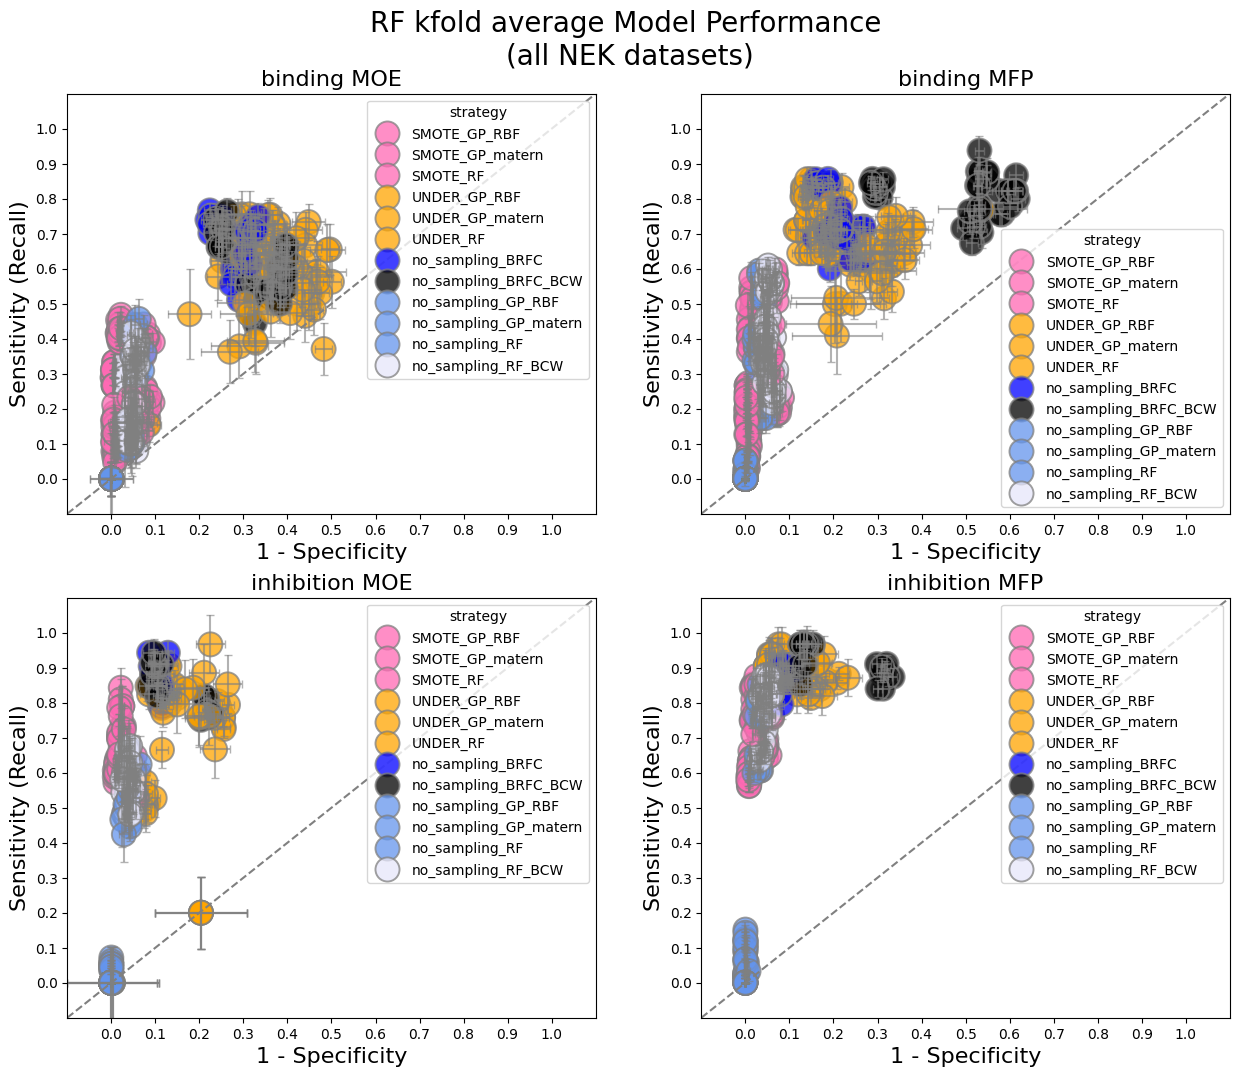

In [17]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([binding, inhib])): 
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    print(this_df.shape)
    moe_avg = moe_df.groupby(['NEK', 'feat_type', 'strategy', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    mfp_avg = mfp_df.groupby(['NEK', 'feat_type', 'strategy', 'iteration'])[['recall', '1-specificity']].mean().reset_index()
    moe_std = moe_avg.groupby(['NEK', 'feat_type', 'strategy' ])[['recall', '1-specificity']].std().reset_index()
    mfp_std = mfp_avg.groupby(['NEK', 'feat_type', 'strategy'])[['recall', '1-specificity']].std().reset_index()
    moe_merged = pd.merge(moe_avg, moe_std, on=['NEK', 'feat_type', 'strategy'], suffixes=('_avg', '_std'))
    mfp_merged = pd.merge(mfp_avg, mfp_std, on=['NEK', 'feat_type', 'strategy'], suffixes=('_avg', '_std'))
    sns.scatterplot(data=moe_avg, x='1-specificity', y='recall', hue='strategy',
                    palette=samp_palette, alpha=0.75, s=300, edgecolor='gray', ax=axs[i, 0])

    axs[i, 0].errorbar(x=moe_merged['1-specificity_avg'], y=moe_merged['recall_avg'],
                       xerr=moe_merged['1-specificity_std'], yerr=moe_merged['recall_std'],
                       fmt='none', ecolor='gray', alpha=0.6, capsize=3)
    sns.scatterplot(data=mfp_avg, x='1-specificity', y='recall', hue='strategy',
                    palette=samp_palette, alpha=0.75, s=300, ax=axs[i, 1], edgecolor='gray')
    
    axs[i, 1].errorbar(x=mfp_merged['1-specificity_avg'], y=mfp_merged['recall_avg'],
                       xerr=mfp_merged['1-specificity_std'], yerr=mfp_merged['recall_std'],
                       fmt='none', ecolor='gray', alpha=0.6, capsize=3)
 
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        # axs[i, j].legend_.remove()
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{mfp_df["nek type"].iloc[0]} MFP', fontsize=16)

plt.suptitle(f'RF kfold average Model Performance \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
# plt.savefig(f'{figs}RF_average_werr.png', bbox_inches='tight')
plt.show();


# GP 

In [16]:
gp_test = pd.read_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val.csv')
gp_train=pd.read_csv(f'{gp_results}GP_train_results_all_NEK_kfold_val.csv')
def extract_strategy(text, segment_index):
    pattern = rf'^(?:[^_]*_){{{segment_index-1}}}([^_]*)'
    match = re.search(pattern, text)
    return match.group(1) if match else None


gp_test['strategy'] = gp_test['model'].apply(lambda x: extract_strategy(x, 4))
# gp_test=gp_test.drop(columns='Unnamed: 0')
gp_test.to_csv(f'{gp_results}GP_test_results_all_NEK_kfold_val.csv',index=False)
gp_train['strategy'] = gp_train['model'].apply(lambda x: extract_strategy(x, 4))
# gp_train=gp_train.drop(columns='Unnamed: 0')
gp_train.to_csv(f'{gp_results}GP_train_results_all_NEK_kfold_val.csv',index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

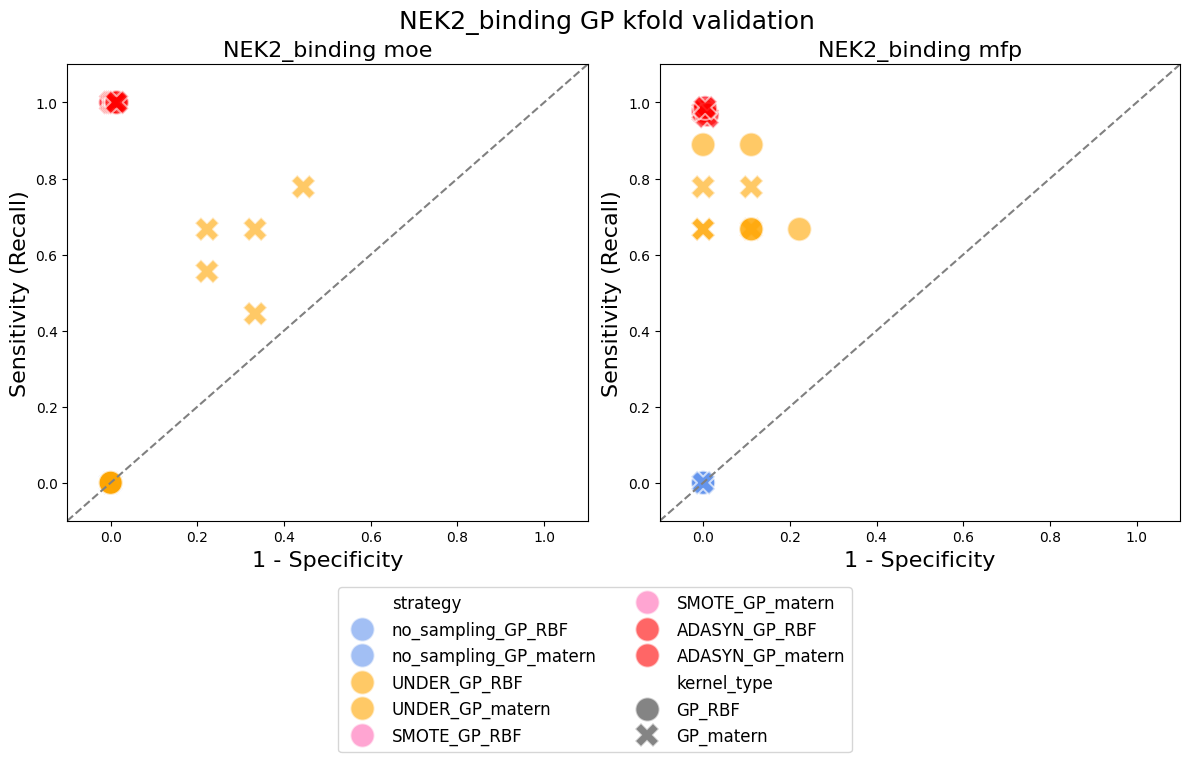

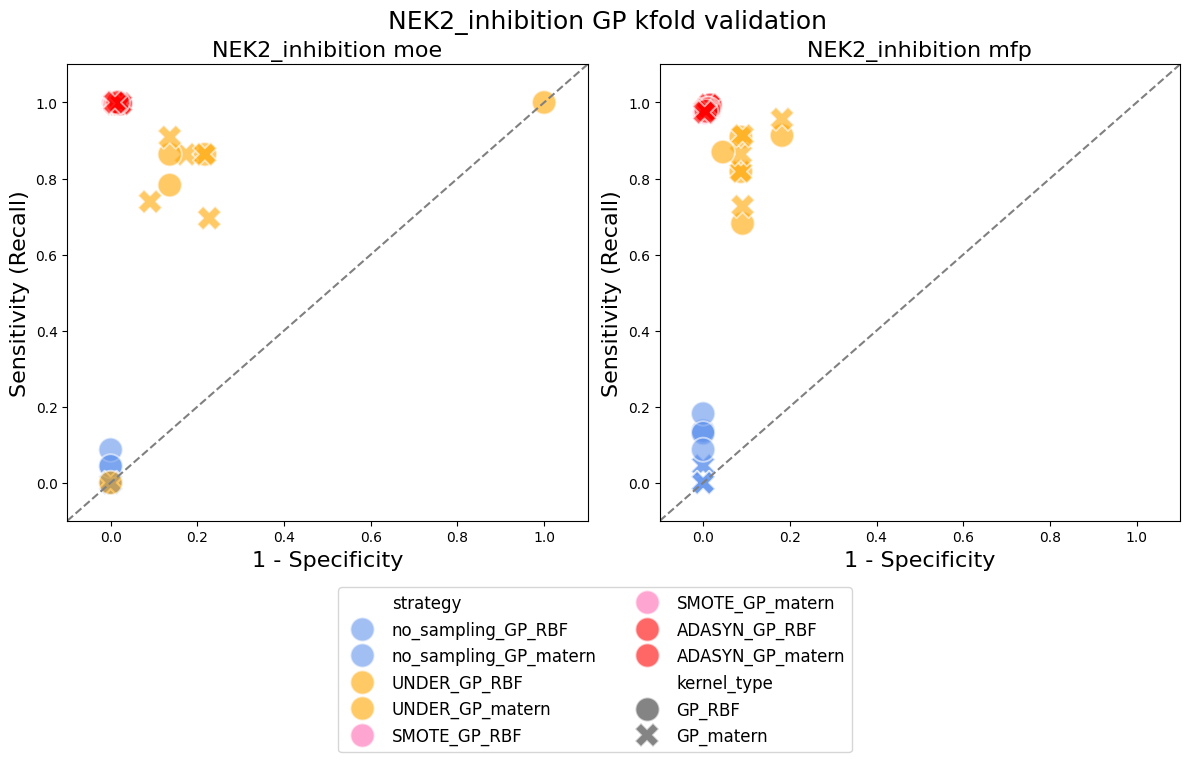

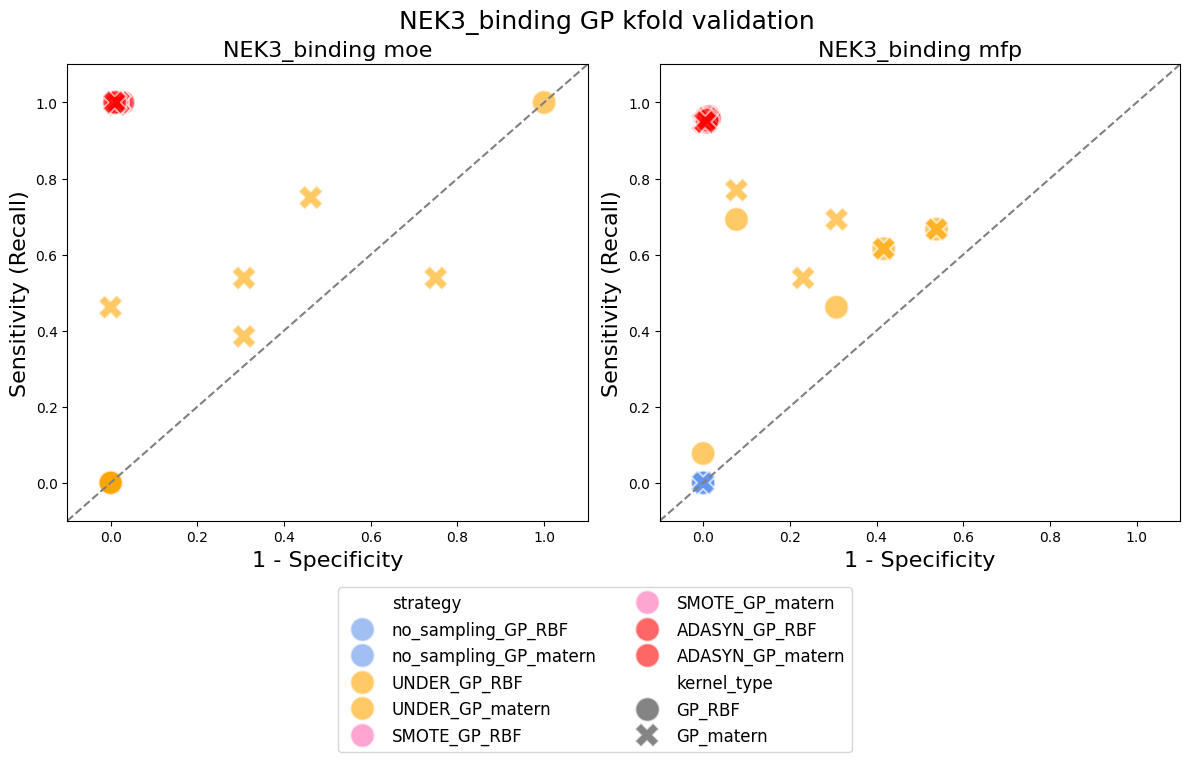

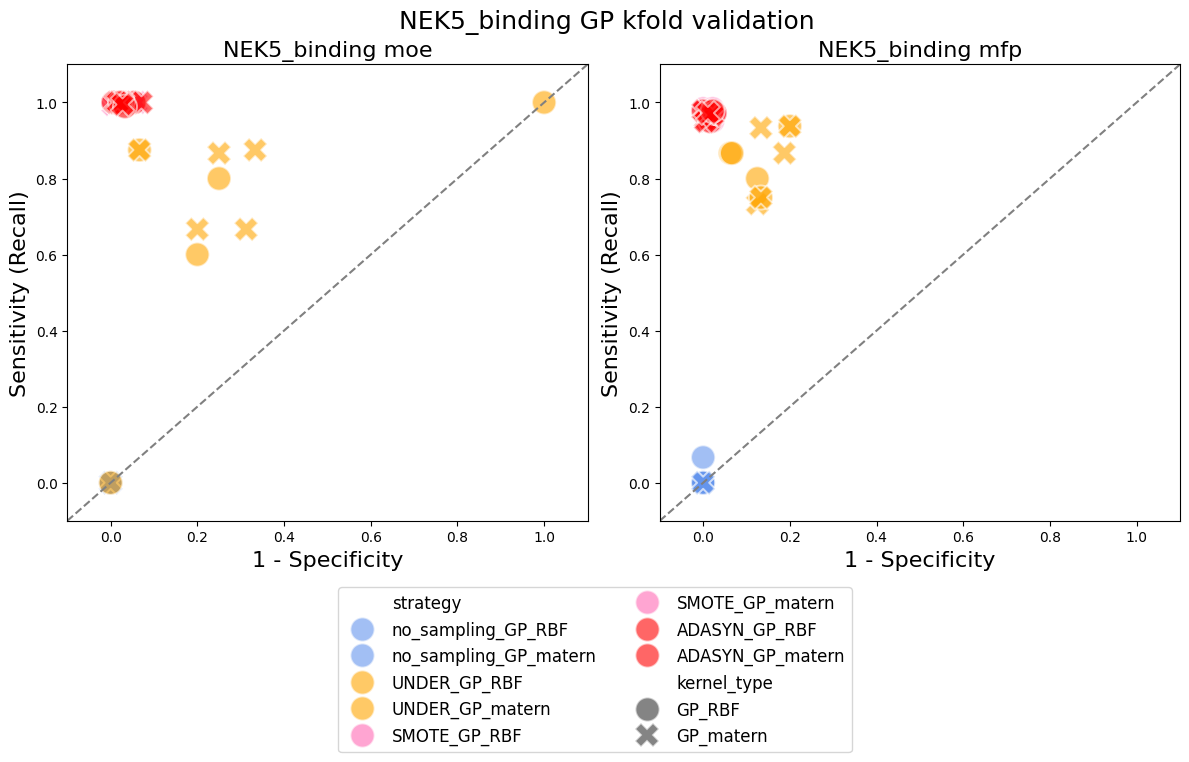

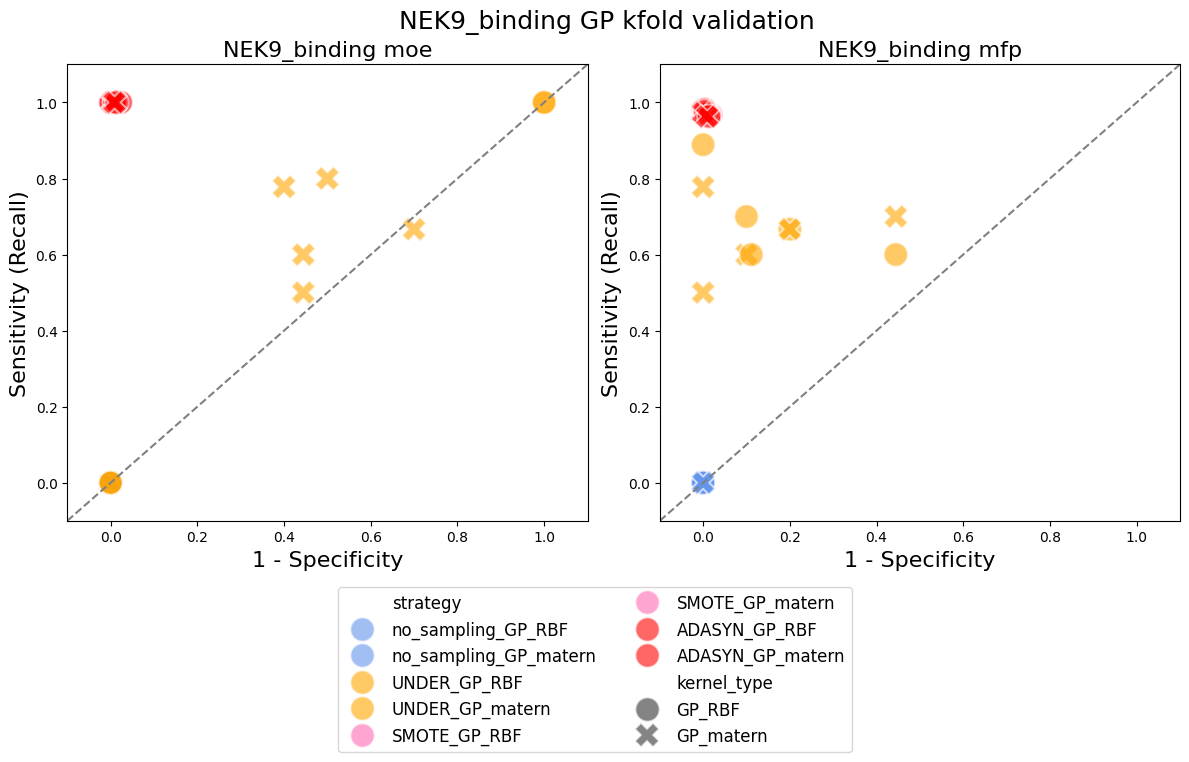

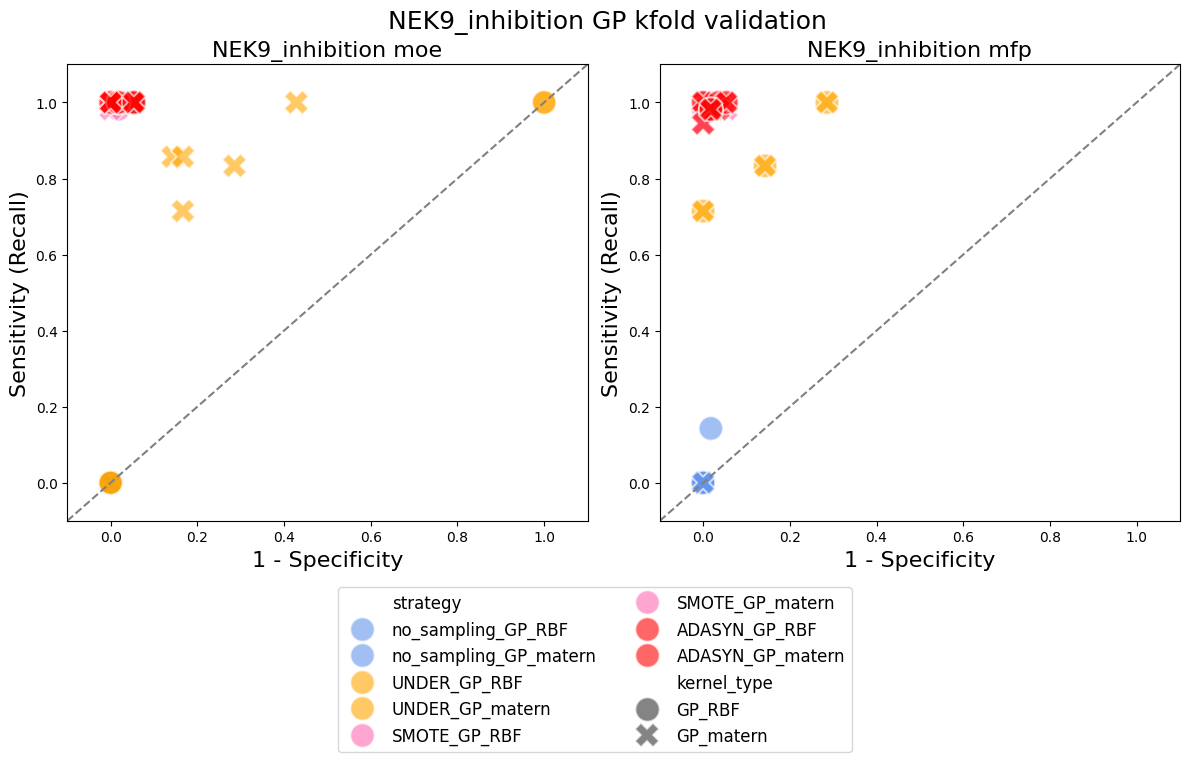

In [17]:
results_dir2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in gp['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp[gp['NEK']==nek]

    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f'{results_dir2}{nek}_GP_kfold_kernel_types.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

In [68]:
results_dir2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/'
for nek in gp2['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp[gp['NEK']==nek]
    
    moe_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MOE')]
    mfp_df = nek_df[(nek_df['NEK'] == nek) & (nek_df['feat_type'] == 'MFP')]
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='fold',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    # plt.savefig(f'{results_dir2}{nek}_GP_kfold.png',bbox_inches='tight')
    plt.tight_layout()
    plt.show();

NameError: name 'gp2' is not defined

In [58]:
gp2 = gp.copy() 
gp2['strategy'] = gp2['strategy'].astype(str).apply(lambda x:x.split('_GP_')[0])
gp2

model              NEK     strategy  \
0       NEK2_binding_MOE_none_scaled_fold1_RBF     NEK2_binding  no_sampling   
1    NEK2_binding_MOE_none_scaled_fold1_matern     NEK2_binding  no_sampling   
2       NEK2_binding_MOE_none_scaled_fold2_RBF     NEK2_binding  no_sampling   
3    NEK2_binding_MOE_none_scaled_fold2_matern     NEK2_binding  no_sampling   
4       NEK2_binding_MOE_none_scaled_fold3_RBF     NEK2_binding  no_sampling   
..                                         ...              ...          ...   
475    NEK9_inhibition_MFP_ADASYN_fold3_matern  NEK9_inhibition       ADASYN   
476       NEK9_inhibition_MFP_ADASYN_fold4_RBF  NEK9_inhibition       ADASYN   
477    NEK9_inhibition_MFP_ADASYN_fold4_matern  NEK9_inhibition       ADASYN   
478       NEK9_inhibition_MFP_ADASYN_fold5_RBF  NEK9_inhibition       ADASYN   
479    NEK9_inhibition_MFP_ADASYN_fold5_matern  NEK9_inhibition       ADASYN   

    feat_type kernel_type   fold              cm    recall  specificity  \
0         MOE      GP_RBF  fold1  [216, 0, 9, 0]  0.000000     1.000000   
1         MOE   GP_matern  fold1  [216, 0, 9, 0]  0.000000     1.000000   
2         MOE      GP_RBF  fold2  [216, 0, 9, 0]  0.000000     1.000000   
3         MOE   GP_matern  fold2  [216, 0, 9, 0]  0.000000     1.000000   
4         MOE      GP_RBF  fold3  [216, 0, 9, 0]  0.000000     1.000000   
..        ...         ...    ...             ...       ...          ...   
475       MFP   GP_matern  fold3  [53, 3, 0, 54]  1.000000     0.946429   
476       MFP      GP_RBF  fold4  [55, 1, 1, 53]  0.981481     0.982143   
477       MFP   GP_matern  fold4  [56, 0, 3, 51]  0.944444     1.000000   
478       MFP      GP_RBF  fold5  [55, 1, 1, 53]  0.981481     0.982143   
479       MFP   GP_matern  fold5  [55, 1, 1, 53]  0.981481     0.982143   

     accuracy  precision        f1   ROC_AUC       MCC  balanced_accuracy  \
0    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
1    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
2    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
3    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
4    0.960000   0.000000  0.000000  0.500000  0.000000           0.500000   
..        ...        ...       ...       ...       ...                ...   
475  0.972727   0.947368  0.972973  0.973214  0.946898           0.973214   
476  0.981818   0.981481  0.981481  0.981812  0.963624           0.981812   
477  0.972727   1.000000  0.971429  0.972222  0.946796           0.972222   
478  0.981818   0.981481  0.981481  0.981812  0.963624           0.981812   
479  0.981818   0.981481  0.981481  0.981812  0.963624           0.981812   

    modeling_type             set  1-specificity    nek type  
0              GP  foldvalidation       0.000000     binding  
1              GP  foldvalidation       0.000000     binding  
2              GP  foldvalidation       0.000000     binding  
3              GP  foldvalidation       0.000000     binding  
4              GP  foldvalidation       0.000000     binding  
..            ...             ...            ...         ...  
475            GP  foldvalidation       0.053571  inhibition  
476            GP  foldvalidation       0.017857  inhibition  
477            GP  foldvalidation       0.000000  inhibition  
478            GP  foldvalidation       0.017857  inhibition  
479            GP  foldvalidation       0.017857  inhibition  

[480 rows x 19 columns]

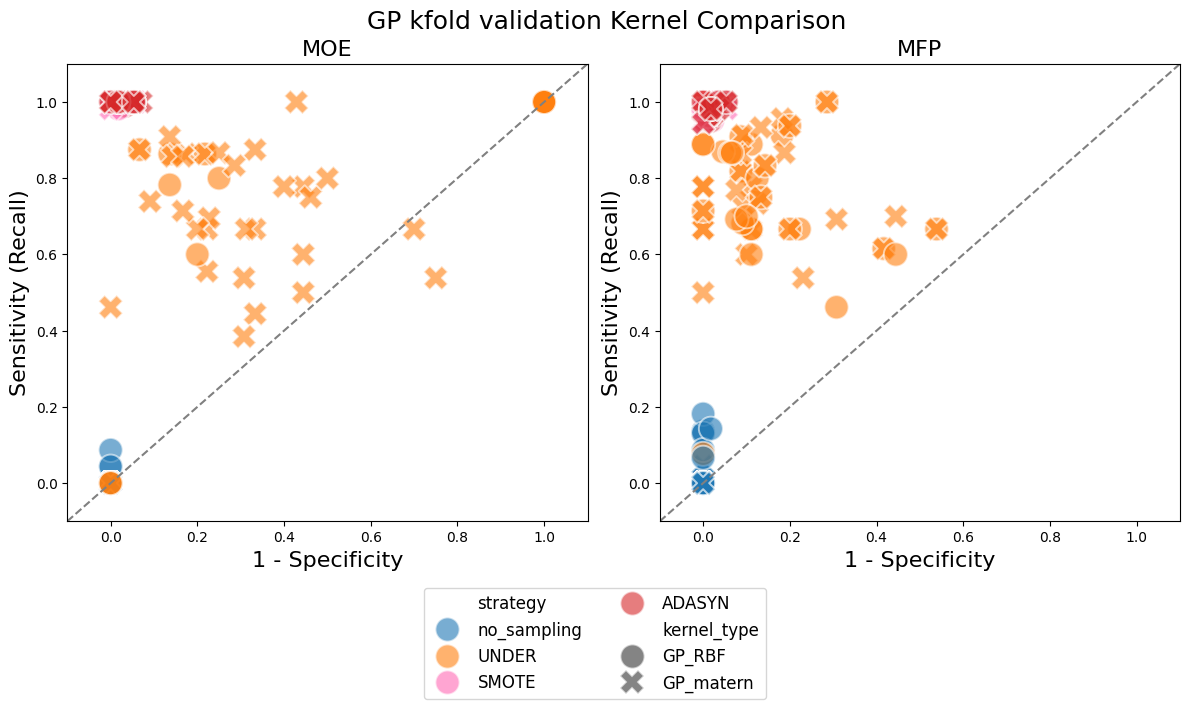

In [61]:

fig, axs = plt.subplots(1,2, figsize=(12,6))


moe_df = gp2[gp2['feat_type'] == 'MOE']
mfp_df =gp2[gp2['feat_type'] == 'MFP']
sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
               s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
              s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
plt.suptitle(f'GP kfold validation Kernel Comparison', fontsize=18, x=0.51, y =.96)
for i, ax in enumerate(axs): 
    axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
    axs[i].set_xlim(-0.1, 1.1)
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xlabel('1 - Specificity', fontsize=16)
    axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)

    
axs[0].set_title(f'MOE', fontsize=16)
axs[1].set_title(f'MFP', fontsize=16)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels,
           loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
axs[0].get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig(f'{results_dir2}GP_RBF_Matern.png',bbox_inches='tight')
plt.tight_layout()
plt.show();

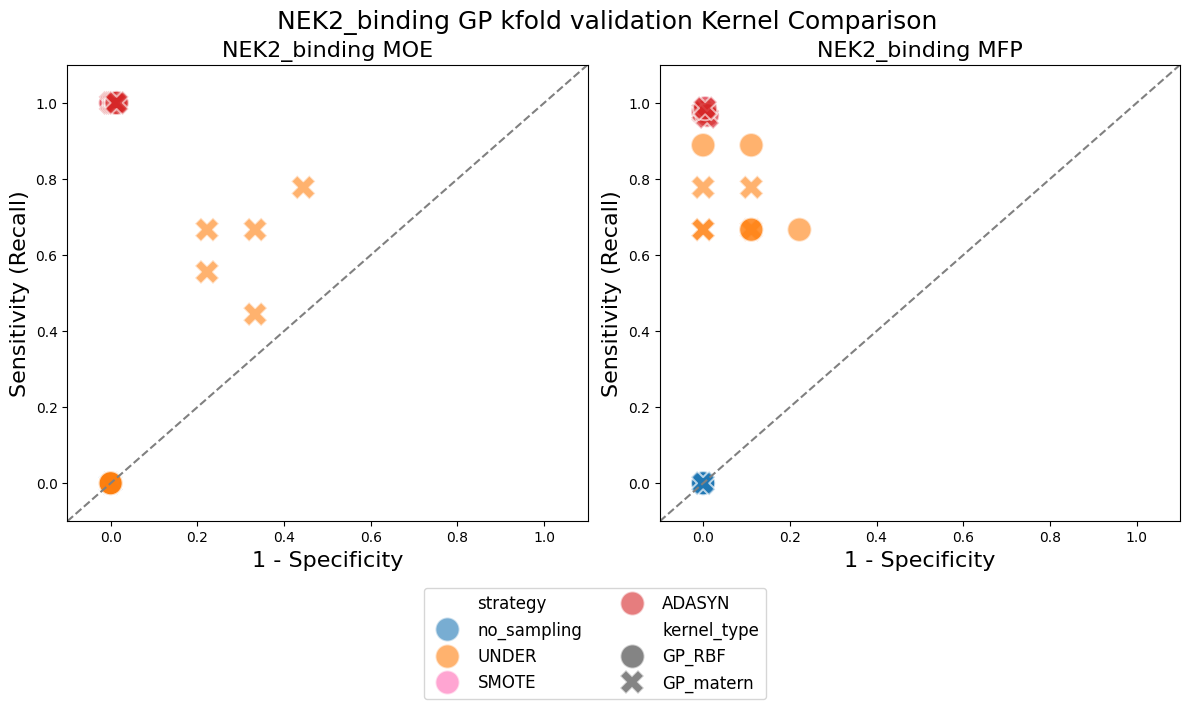

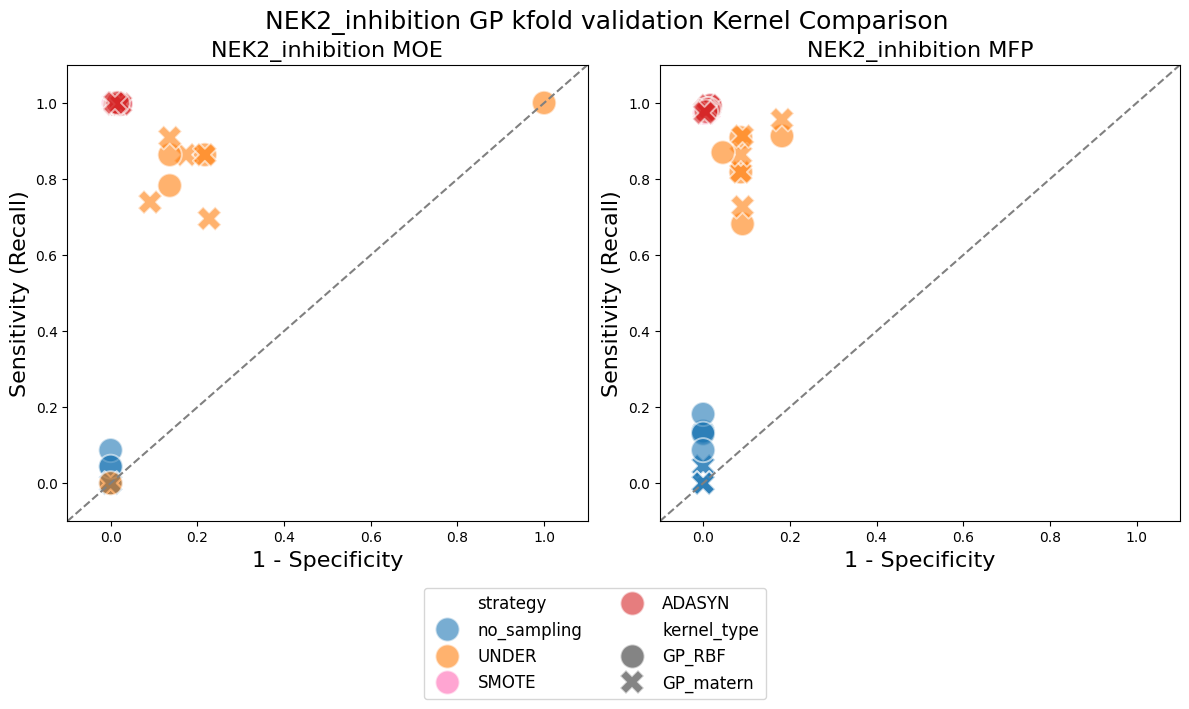

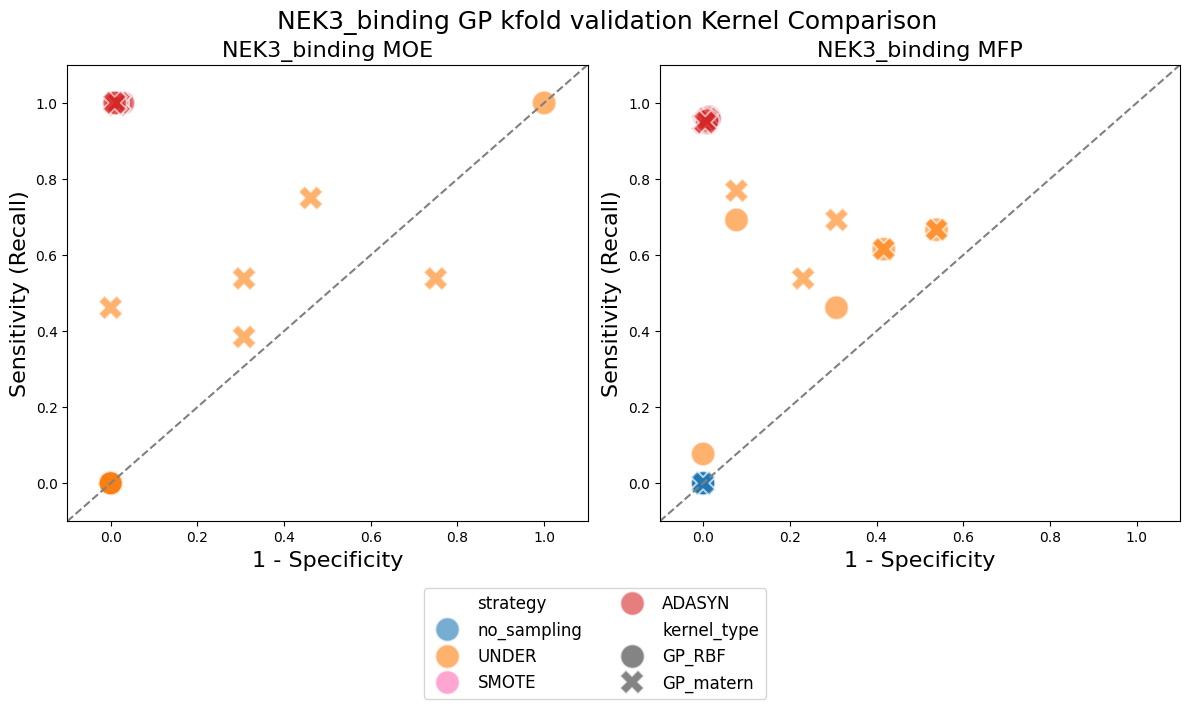

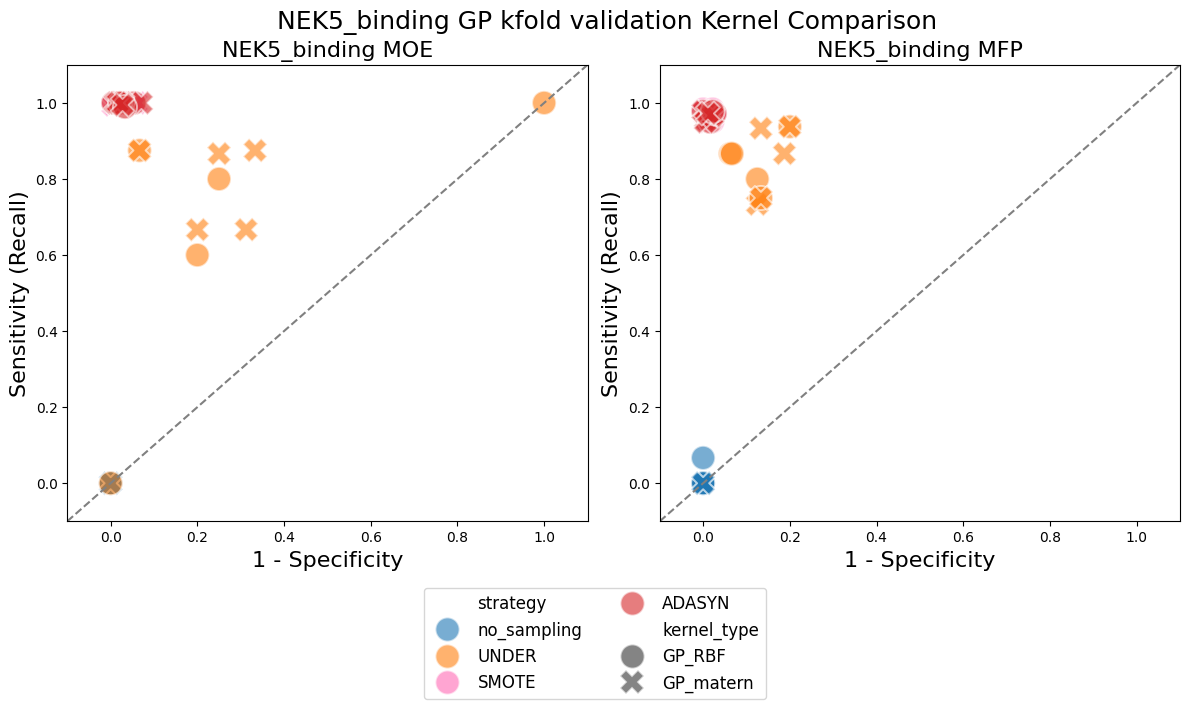

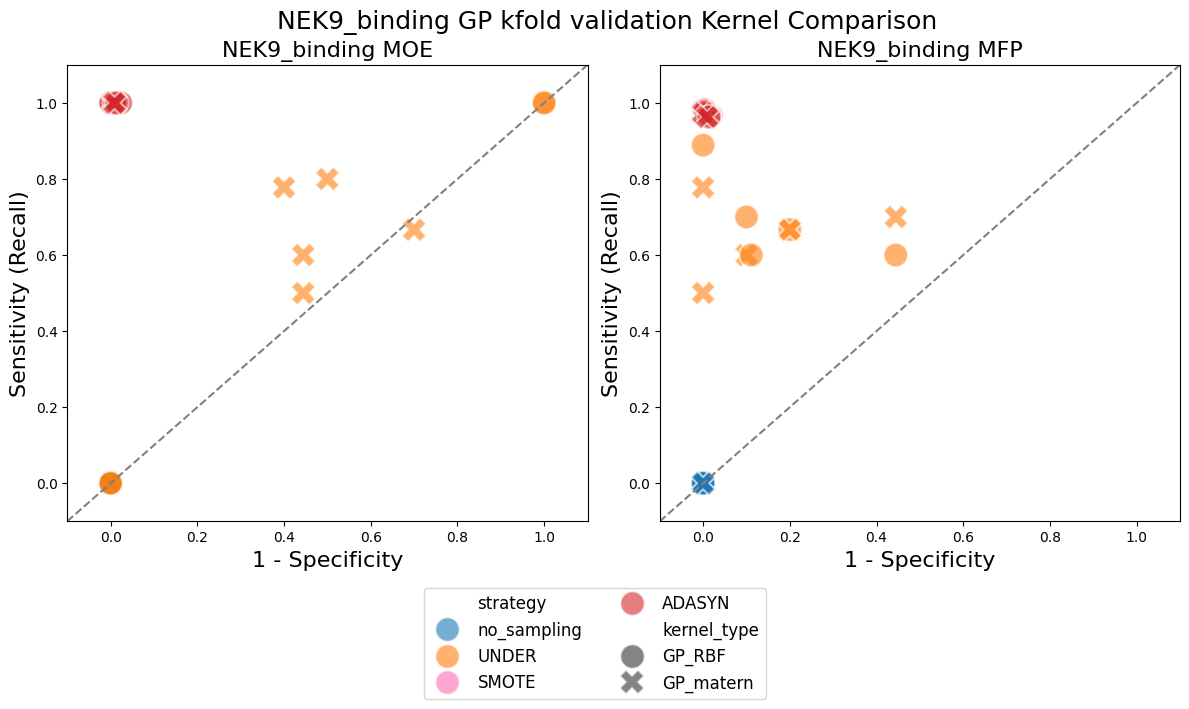

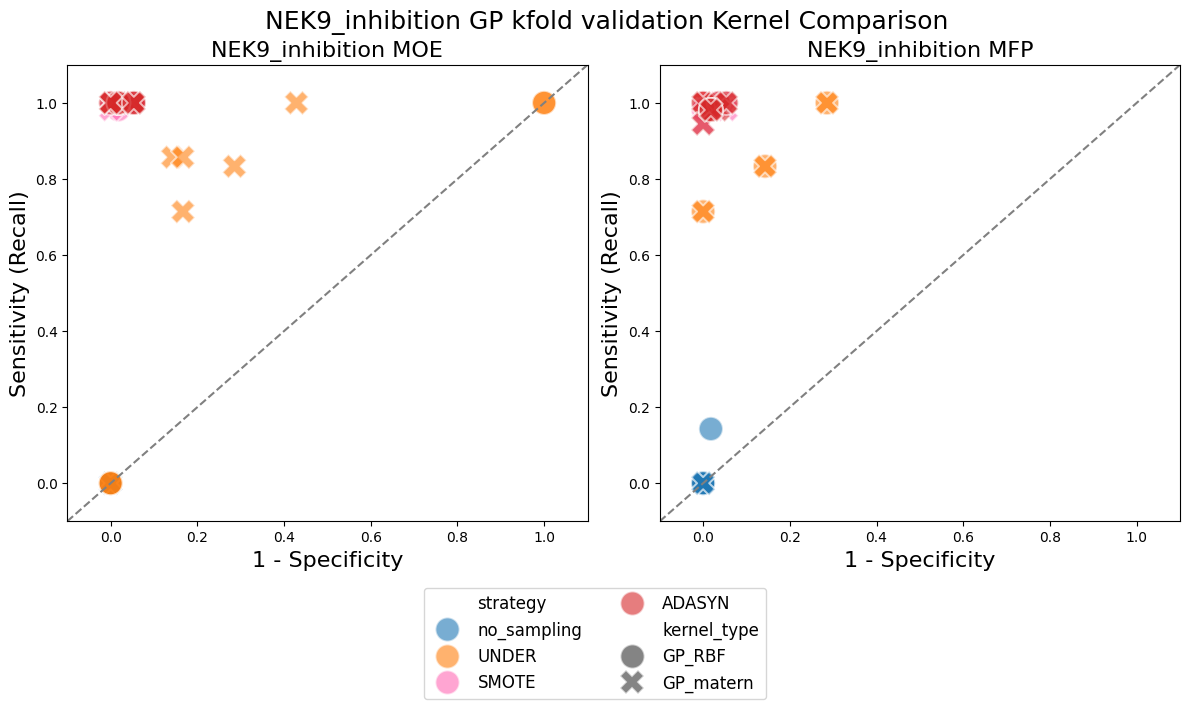

In [63]:
for nek in gp2['NEK'].unique():     
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    nek_df = gp2[gp2['NEK'] == nek] 
    moe_df = nek_df[nek_df['feat_type'] == 'MOE']
    mfp_df =nek_df[nek_df['feat_type'] == 'MFP']
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   s=300, alpha=0.6, ax=axs[0], legend=True, palette=samp_palette )
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                  s=300, alpha=0.6, ax=axs[1], legend=False, palette=samp_palette )
    plt.suptitle(f'{nek} GP kfold validation Kernel Comparison', fontsize=18, x=0.51, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    
        
    axs[0].set_title(f'{nek} MOE', fontsize=16)
    axs[1].set_title(f'{nek} MFP', fontsize=16)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, .01), ncol=2, fontsize=12)
    axs[0].get_legend().remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 

    plt.tight_layout()
    plt.show();

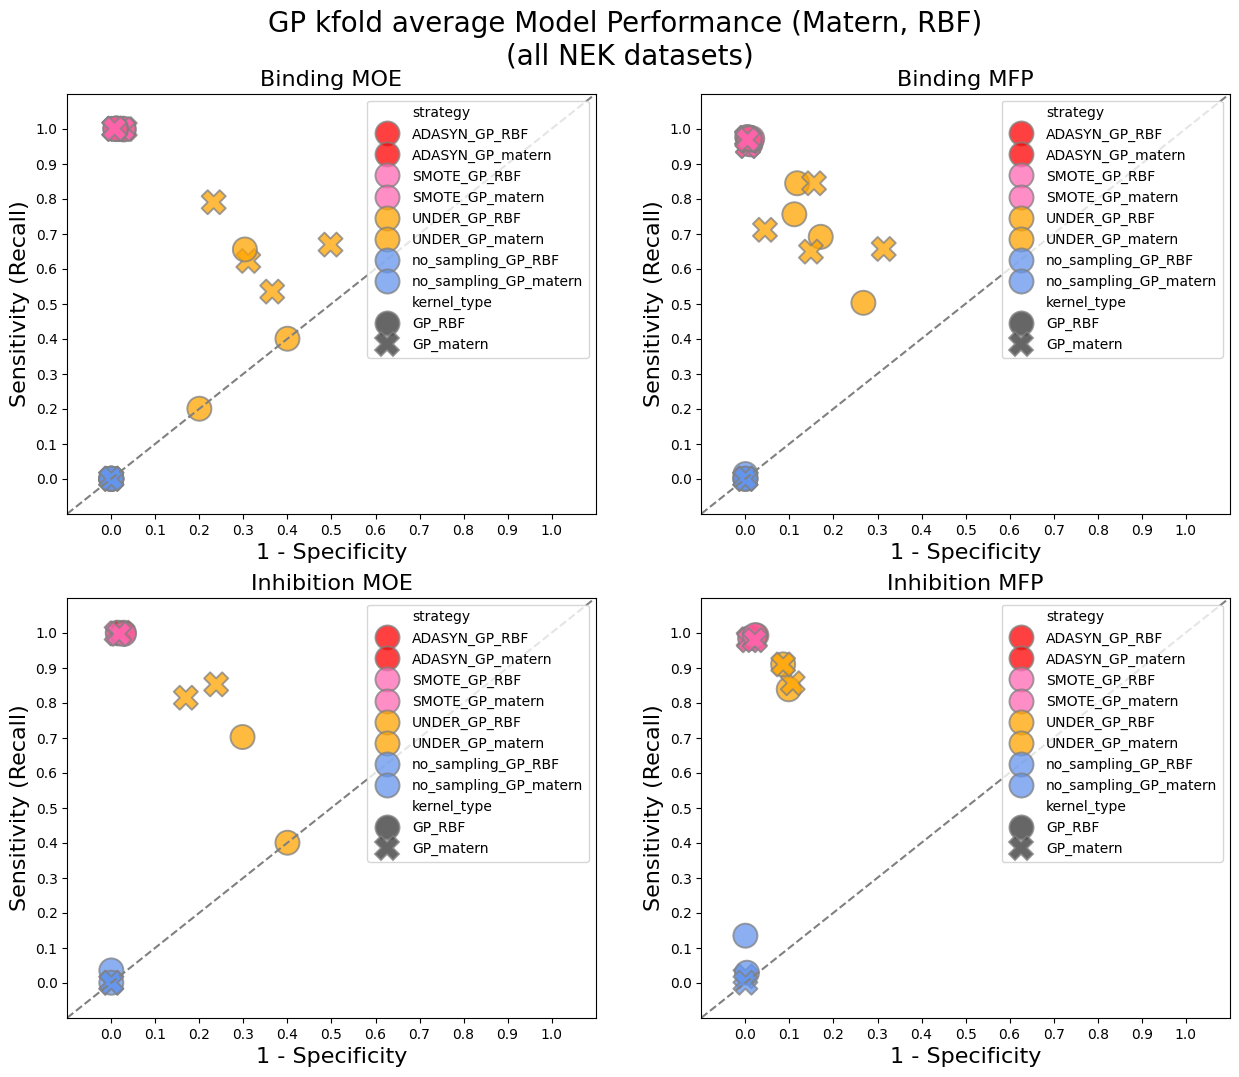

In [73]:
binding_avg_gp = binding_gp.groupby(['NEK','feat_type', 'strategy', 'kernel_type'])[['recall', '1-specificity']].mean()
binding_avg_df_gp=binding_avg_gp.reset_index()
inhib_avg_gp = inhib_gp.groupby(['NEK','feat_type', 'strategy','kernel_type'])[['recall', '1-specificity']].mean()
inhib_avg_df_gp=inhib_avg_gp.reset_index()
inhib_avg_df
fig, axs = plt.subplots(2,2, figsize=(15,12))

for i, this_df in enumerate(list([binding_avg_df_gp, inhib_avg_df_gp])): 
    moe_df =this_df[this_df['feat_type'] == 'MOE']
    mfp_df = this_df[this_df['feat_type'] == 'MFP']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',  style='kernel_type',
                   alpha=0.75,s=300, edgecolor='gray', ax=axs[i,0], palette=samp_palette)
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='kernel_type',
                   alpha=0.75, s=300,legend=True, ax=axs[i,1],edgecolor='gray', palette=samp_palette)
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        
        # axs[i, j].legend_.remove()
    
    axs[0, 0].set_title(f'Binding MOE', fontsize=16)
    axs[0, 1].set_title(f'Binding MFP', fontsize=16)
    axs[1, 0].set_title(f'Inhibition MOE', fontsize=16)
    axs[1, 1].set_title(f'Inhibition MFP', fontsize=16)

plt.suptitle(f'GP kfold average Model Performance (Matern, RBF) \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
plt.savefig(f'{results_dir2}GP_averages.png', bbox_inches='tight')
plt.show();


In [28]:
# RF kfold Results
rf = pd.read_csv(f'{rf_results}RF_test_results_all_NEK_kfold_val_10x.csv')
rf['1-specificity']=1-rf['specificity']
rf['nek type'] = rf['NEK'].astype(str).str.split('_').str[1]
rf=rf.replace('none_scaled', 'no_sampling')


rf_raw = rf[(rf['strategy'] == 'no_sampling') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'SMOTE', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
total_rf = rf_filtered.copy() 

rf_os= total_rf[(total_rf['strategy']=='SMOTE') | (total_rf['strategy']=='ADASYN')]
rf_avg = rf_os.groupby(['NEK', 'feat_type', 'strategy'])[['recall','specificity', '1-specificity']].mean()
rf_avg_revert = rf_avg.reset_index()
for nek in rf_avg_revert['NEK'].unique(): 
    nek_df = rf_avg_revert[rf_avg_revert['NEK']==nek]
    display(nek_df)

NEK feat_type strategy    recall  specificity  1-specificity
0  NEK2_binding       MFP   ADASYN  0.324444     0.953704       0.046296
1  NEK2_binding       MFP    SMOTE  0.346667     0.949630       0.050370
2  NEK2_binding       MOE   ADASYN  0.335556     0.947685       0.052315
3  NEK2_binding       MOE    SMOTE  0.344444     0.948426       0.051574

NEK feat_type strategy    recall  specificity  1-specificity
4  NEK2_inhibition       MFP   ADASYN  0.632925     0.952478       0.047522
5  NEK2_inhibition       MFP    SMOTE  0.669368     0.954458       0.045542
6  NEK2_inhibition       MOE   ADASYN  0.570870     0.945674       0.054326
7  NEK2_inhibition       MOE    SMOTE  0.572767     0.950632       0.049368

NEK feat_type strategy    recall  specificity  1-specificity
8   NEK3_binding       MFP   ADASYN  0.223077     0.929869       0.070131
9   NEK3_binding       MFP    SMOTE  0.218333     0.926565       0.073435
10  NEK3_binding       MOE   ADASYN  0.178718     0.917846       0.082154
11  NEK3_binding       MOE    SMOTE  0.176795     0.917485       0.082515

NEK feat_type strategy    recall  specificity  1-specificity
12  NEK5_binding       MFP   ADASYN  0.553500     0.936507       0.063493
13  NEK5_binding       MFP    SMOTE  0.550333     0.932775       0.067225
14  NEK5_binding       MOE   ADASYN  0.377333     0.921943       0.078057
15  NEK5_binding       MOE    SMOTE  0.365833     0.924026       0.075974

NEK feat_type strategy    recall  specificity  1-specificity
16  NEK9_binding       MFP   ADASYN  0.342222     0.949910       0.050090
17  NEK9_binding       MFP    SMOTE  0.358444     0.945827       0.054173
18  NEK9_binding       MOE   ADASYN  0.205111     0.942030       0.057970
19  NEK9_binding       MOE    SMOTE  0.216667     0.939802       0.060198

NEK feat_type strategy    recall  specificity  1-specificity
20  NEK9_inhibition       MFP   ADASYN  0.780952     0.957857       0.042143
21  NEK9_inhibition       MFP    SMOTE  0.799048     0.948214       0.051786
22  NEK9_inhibition       MOE   ADASYN  0.610476     0.953929       0.046071
23  NEK9_inhibition       MOE    SMOTE  0.598571     0.949643       0.050357

In [2]:
# RF kfold 
path2= '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_kfold_results/'

In [219]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    The input confusion matrix is expected to be in the order [TN, FP, FN, TP].
    """
    # Convert the string to a list of integers
    cm_values = list(map(int, cm.split(',')))  # Split the string and convert to integers

    # Reshape the confusion matrix into a 2x2 array
    cm_reshaped = np.array([[cm_values[0], cm_values[1]], [cm_values[2], cm_values[3]]])

    # Normalize the confusion matrix if requested
    if normalize:
        cm_reshaped = cm_reshaped.astype('float') / cm_reshaped.sum(axis=1)[:, np.newaxis]

    # Create the plot
    plt.figure(figsize=(6, 4))
    fig, ax = plt.subplots()

    # Plot the confusion matrix
    im = ax.imshow(cm_reshaped, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Set ticks and labels
    ax.set(xticks=np.arange(cm_reshaped.shape[1]),
           yticks=np.arange(cm_reshaped.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and align them
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions to add text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm_reshaped.max() / 2.
    for i in range(cm_reshaped.shape[0]):
        for j in range(cm_reshaped.shape[1]):
            ax.text(j, i, format(cm_reshaped[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_reshaped[i, j] > thresh else "black", fontsize=18)

    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

    return ax

# Now call the function with the string from nek3bindgp['cm']
cm_string = nek3bindgp['cm']  # This is the string, e.g., "50, 10, 5, 60"
plot_confusion_matrix(cm_string, ['inactive', 'active'], normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues)


AttributeError: 'Series' object has no attribute 'split'

In [220]:
print(nek3bindgp['cm'])

# Assuming it's a Pandas Series or similar, we will convert it to a NumPy array
cm = nek3bindgp['cm'].values if isinstance(nek3bindgp['cm'], pd.Series) else np.array(nek3bindgp['cm'])


203    [170, 42, 5, 8]
Name: cm, dtype: object
